# Download data from Kaggle 📥

In [75]:
!pip install -q kaggle

In [76]:
# Go to your Kaggle account and navigate to your account settings (click on your profile picture -> "Account").
# Scroll down to the "API" section and click "Create New API Token." This will download a kaggle.json file containing your API key.
# In your Colab notebook, run the following code to upload the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"revanthadurti","key":"28e9d125672510bcd7a7966f8146b87c"}'}

In [77]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [78]:
! cp kaggle.json ~/.kaggle/

In [79]:
!kaggle datasets download -d dgawlik/nyse

Dataset URL: https://www.kaggle.com/datasets/dgawlik/nyse
License(s): CC0-1.0
nyse.zip: Skipping, found more recently modified local copy (use --force to force download)


# Extract data and install packages (regardless of data acquisition method) 🚀

In [80]:
!unzip nyse.zip

Archive:  nyse.zip
replace fundamentals.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [81]:
### TODO: Install required packages
### Student's code here
!pip install pandas
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn
### END

## **Library and Data Imports**
- Import your libraries and the data here

In [114]:
from re import I
### TODO: Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
###

## **Q1: Market Entry and Exit Dynamics Analysis (10 Points)**
Identify which companies in the dataset entered after data collection started (presumably new companies) and which left the exchange before the end date for data collection (perhaps going bankrupt)

In [83]:
df = pd.read_csv('/content/prices.csv')

In [84]:
#normalizing the date data
df['date'] = pd.to_datetime(df['date'],format='ISO8601')
#finding out the first trade and the last trade of each comapny
first_trade = df.groupby('symbol')['date'].min().reset_index()
last_trade = df.groupby('symbol')['date'].max().reset_index()
#intializing start date and end date
start_date = '2010-01-04'
end_date= '2016-12-30'
#filtering the dataframes using start date and end date
newListingsdf = first_trade[first_trade['date'] > start_date]
goneFromListingdf = last_trade[last_trade['date'] < end_date]
newListings = newListingsdf['symbol'].tolist()
goneFromListing = goneFromListingdf['symbol'].tolist()
print(newListings)
print(goneFromListing)

['ABBV', 'ALLE', 'CFG', 'CHTR', 'COTY', 'CSRA', 'DLPH', 'EVHC', 'FB', 'FBHS', 'FTV', 'GM', 'HCA', 'HPE', 'KHC', 'KMI', 'KORS', 'LYB', 'MNK', 'MPC', 'NAVI', 'NLSN', 'NWS', 'NWSA', 'PSX', 'PYPL', 'QRVO', 'SYF', 'TDG', 'TRIP', 'WLTW', 'WRK', 'XYL', 'ZTS']
[]


## **Q2: Ranking and Sampling (10 Points)**
Order the companies by how big/interesting/important they are, so we can restrict    analysis to the top n companies to work with to keep future computations reasonable.  Describe what ranking feature you think best here and why, and what n works for you for future analysis **given your limited compute environment**.

In [85]:
fundamentals = pd.read_csv('fundamentals.csv')
prices = pd.read_csv('prices.csv')
fundamentals.rename(columns={'Ticker Symbol': 'symbol', 'For Year' : 'Year'}, inplace=True)
prices['date'] = pd.to_datetime(prices['date'], format='ISO8601')
prices['Year'] = prices['date'].dt.year

prices = prices.dropna(subset=['symbol', 'close'])
fundamentals = fundamentals.dropna(subset=['symbol', 'Estimated Shares Outstanding', 'Year'])
fundamentals = fundamentals.dropna(subset=['Year'])

avg_close = prices.groupby(['symbol', 'Year'])['close'].mean().reset_index()
avg_close.rename(columns={'close': 'Avg_Close_Price'}, inplace=True)
fundamentals['Estimated Shares Outstanding'] = pd.to_numeric(fundamentals['Estimated Shares Outstanding'])
fundamentals = fundamentals.dropna(subset=['Estimated Shares Outstanding'])
outstanding_shares = fundamentals.groupby(['symbol', 'Year'])['Estimated Shares Outstanding'].mean().reset_index()
merged = pd.merge(avg_close, outstanding_shares, on=['symbol', 'Year'], how='inner')

merged['Market_Cap'] = merged['Avg_Close_Price'] * merged['Estimated Shares Outstanding']

# Optionally, convert Market Cap to billions for readability
merged['Market_Cap_Billion'] = merged['Market_Cap'] / 1e9

avg_market_cap = merged.groupby('symbol')['Market_Cap_Billion'].mean().reset_index()
avg_market_cap
avg_market_cap.rename(columns={'Market_Cap_Billion': 'Avg_Market_Cap_Billion'}, inplace=True)
avg_market_cap = avg_market_cap.sort_values(by=['Avg_Market_Cap_Billion'], ascending=False)
mean_eps_list = avg_market_cap['symbol'].tolist()
importantCompanies = mean_eps_list[:20]
importantCompanies

['AAPL',
 'XOM',
 'MSFT',
 'MA',
 'WFC',
 'WMT',
 'JPM',
 'CVX',
 'KO',
 'IBM',
 'PFE',
 'T',
 'BAC',
 'FB',
 'AMZN',
 'VZ',
 'DIS',
 'MRK',
 'C',
 'INTC']

Discussion for Q2:


## **Q3: Stock Split Analysis (15 Points)**
There are two datafiles, one with raw prices, the other adjusted by stock splits.   Compare the pre-and-post split files to see if you can identify the dates/companies of the roughly 140 stock splits and what the ratio of each of the splits were.

In [134]:
from re import sub
df = pd.read_csv('/content/prices.csv')
df['date'] = pd.to_datetime(df['date'],format='ISO8601')
df = df.sort_values(by=['symbol','date'])
adjustedDf = pd.read_csv('/content/prices-split-adjusted.csv')
adjustedDf['date'] = pd.to_datetime(adjustedDf['date'],format='ISO8601')
adjustedDf = adjustedDf.sort_values(by=['symbol','date'])
merged_df = pd.merge(df, adjustedDf, on=['symbol', 'date'])
merged_df['close_ratios'] = round(merged_df['close_y']/merged_df['close_x'],3)
merged_df = merged_df.drop(merged_df[merged_df['close_ratios'] == 1.0].index)
merged_df = merged_df.drop_duplicates(subset=['symbol','close_ratios'],keep='last')
merged_df

date symbol      open_x     close_x       low_x      high_x  \
1216   2014-10-31      A   55.209998   55.279998   54.849998   55.410000   
6399   2014-06-06   AAPL  649.900002  645.570023  644.470024  651.259979   
10571  2012-12-31    ABT   64.129942   65.499944   64.009943   65.529941   
19821  2014-09-30    ADP   83.340006   83.080005   82.700005   83.450003   
45613  2012-03-16    ALK   71.750000   69.790001   69.500000   72.339996   
...           ...    ...         ...         ...         ...         ...   
802945 2010-07-01     VZ   28.009890   28.129890   27.599891   28.199888   
810160 2011-03-01    WEC   59.500000   58.639999   58.639999   59.520000   
814248 2013-05-29    WFM  105.419998  105.410004  104.800003  106.269997   
819433 2011-12-30    WMB   32.609923   33.019920   32.539928   33.109923   
846710 2016-10-31    YUM   86.330001   86.280000   85.580000   86.340003   

          volume_x     open_y    close_y      low_y     high_y    volume_y  \
1216     2918700.0  39.492130  39.542202  39.234619  39.635193   2918700.0   
6399    87484600.0  92.842857  92.224289  92.067146  93.037140  87484600.0   
10571   19018100.0  30.769546  31.426873  30.711971  31.441266  19018100.0   
19821    2356100.0  73.169452  72.941181  72.607555  73.266025   2356100.0   
45613    7539200.0  17.937500  17.447500  17.375000  18.084999   7539200.0   
...            ...        ...        ...        ...        ...         ...   
802945  32420000.0  26.272969  26.385527  25.888394  26.451185  32420000.0   
810160   3096200.0  29.750000  29.320000  29.320000  29.760000   3096200.0   
814248   4064800.0  52.709999  52.705002  52.400002  53.134999   4064800.0   
819433   8067200.0  26.583609  26.917839  26.526549  26.991209   8067200.0   
846710   5419200.0  62.063265  62.027318  61.524083  62.070455   5419200.0   

        close_ratios  
1216           0.715  
6399           0.143  
10571          0.480  
19821          0.878  
45613          0.250  
...              ...  
802945         0.938  
810160         0.500  
814248         0.500  
819433         0.815  
846710         0.719  

[133 rows x 13 columns]

Discussion for Q3: The above code reveals when there was a stock split, I took a ratio of closing prices in adjusted and raw files. Then removed where there was no change and thus we get the dates and the ratios in of the stock splits

## **Q4: Pairs Trading Strategy and Correlation Analysis (20 Points)**
Pairs trading is an investment strategy which relies on identifying pairs of stocks which move in the same direction each day – if stock A goes up (down) on a given day, then stock B likely goes up (down) the same day.   So:

<ol type="a">
 <li>Construct an appropriate daily time series for each stock reflecting how much it goes up or down each day.</li>
 <li>Construct a pairwise correlation matrix measuring how in sync these movements are among all pairs of your n top stocks.   Present this pairwise correlation matrix in a way to make its lesson as clear as possible to the viewer.</li>
 <li>Identify which pairs are most and least strongly correlated in their movements, and propose some reasonable explanations why this is the case.</li>
 <li> The 'securities.csv' file contains the economic sector which each company participates in.  Do companies within the same economic sector have stronger or weaker price correlations than those in different sectors? </li>
</ol>



### **Part a**

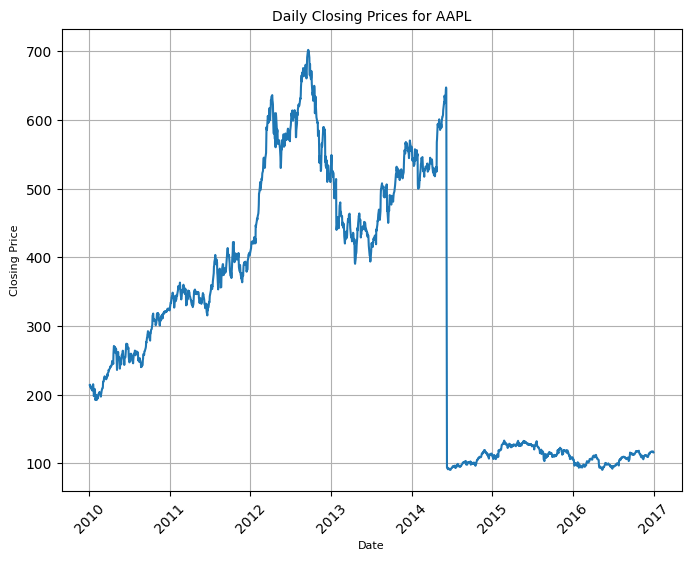

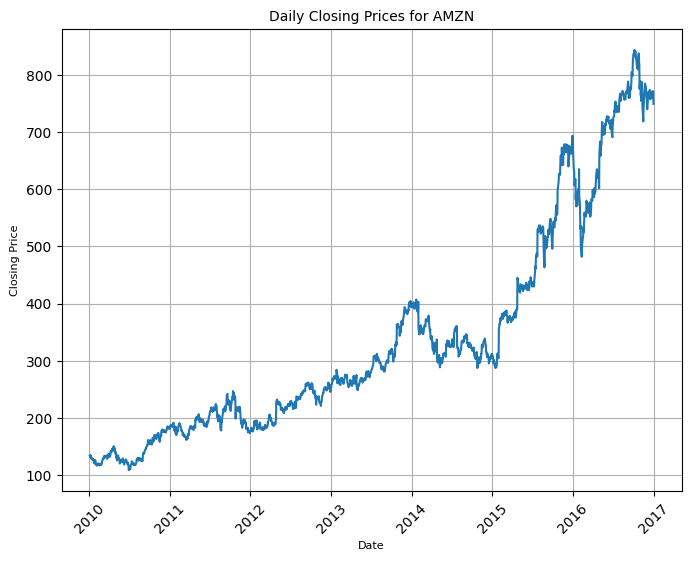

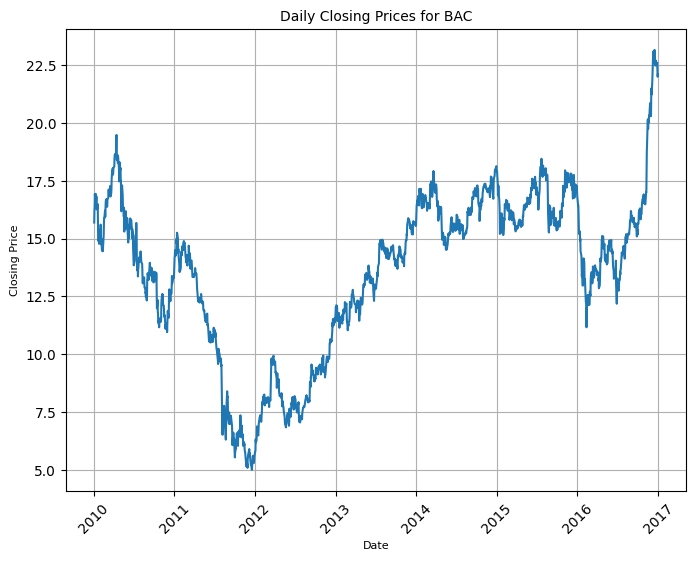

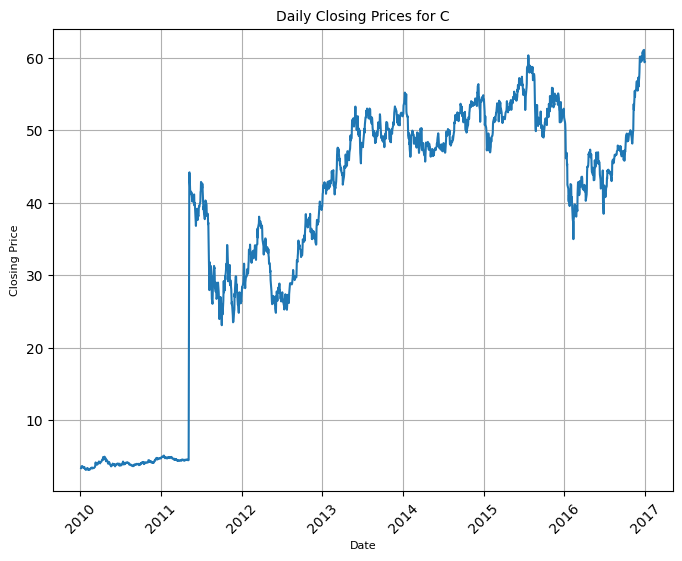

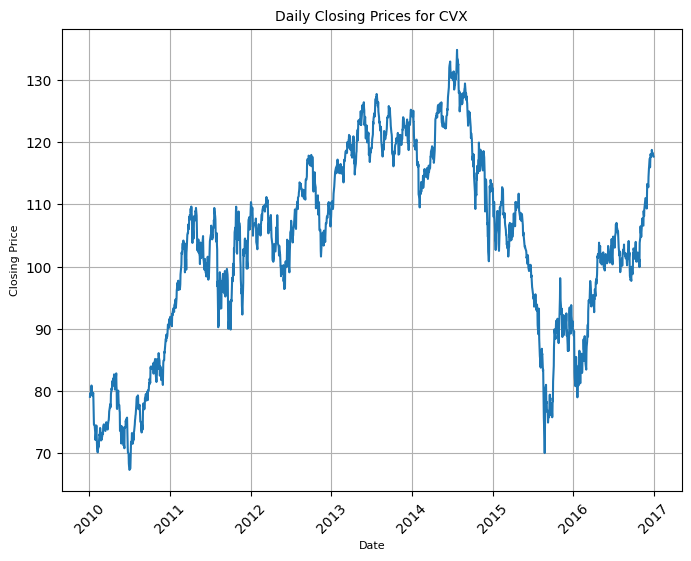

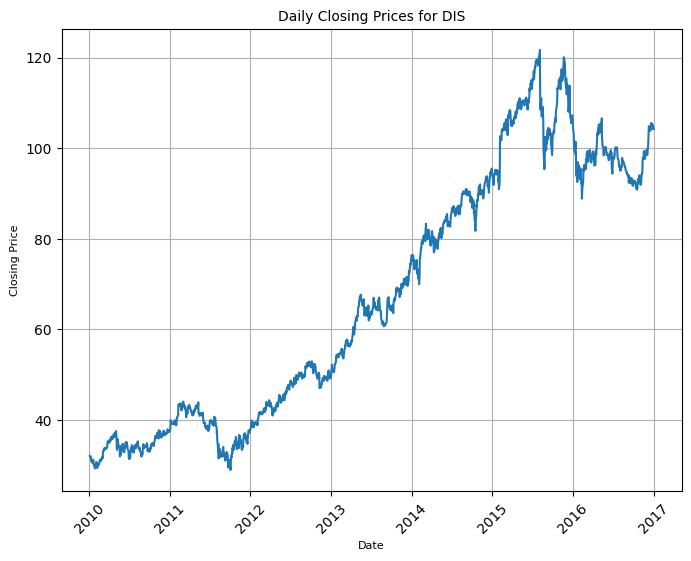

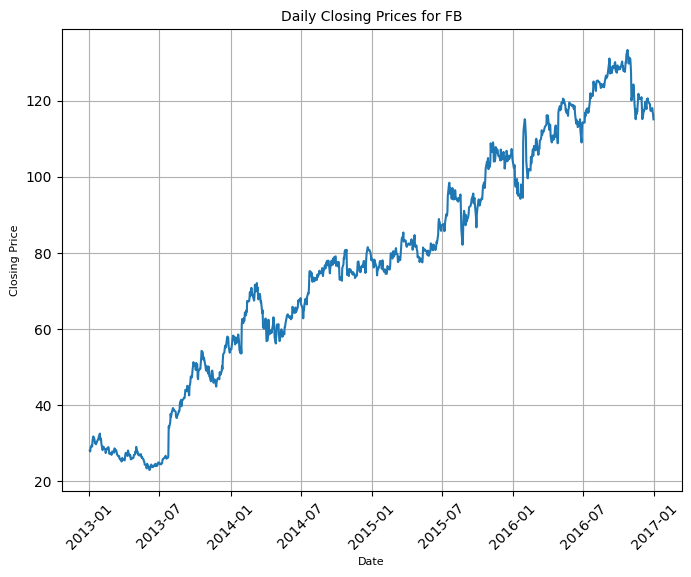

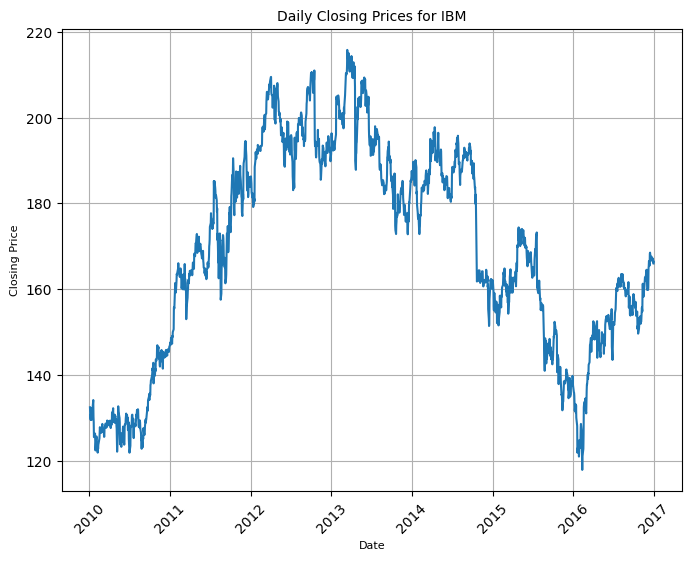

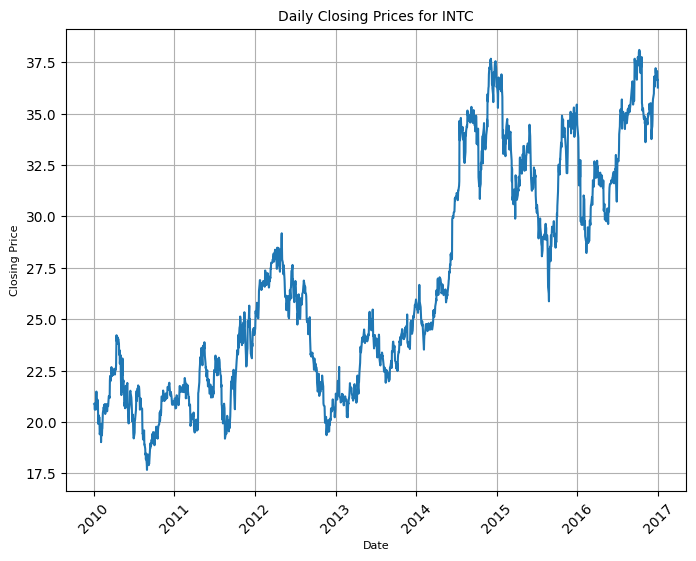

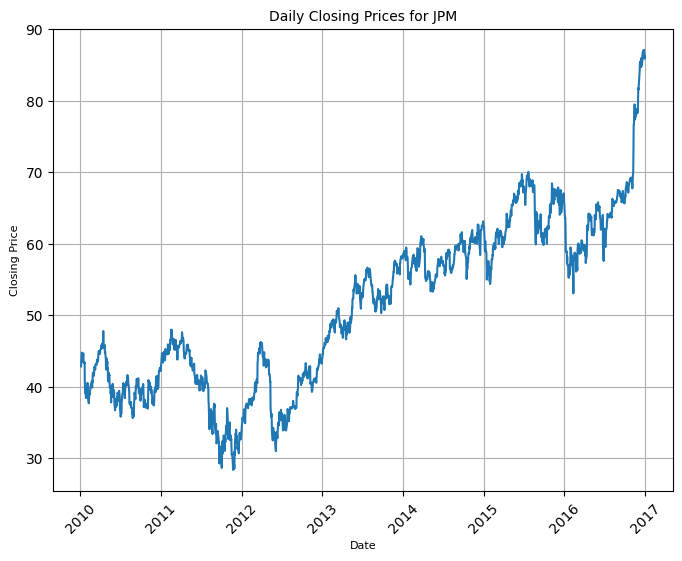

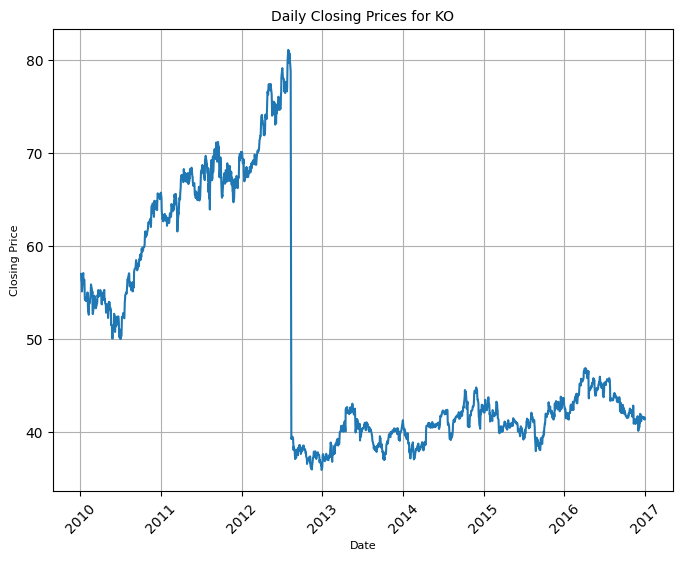

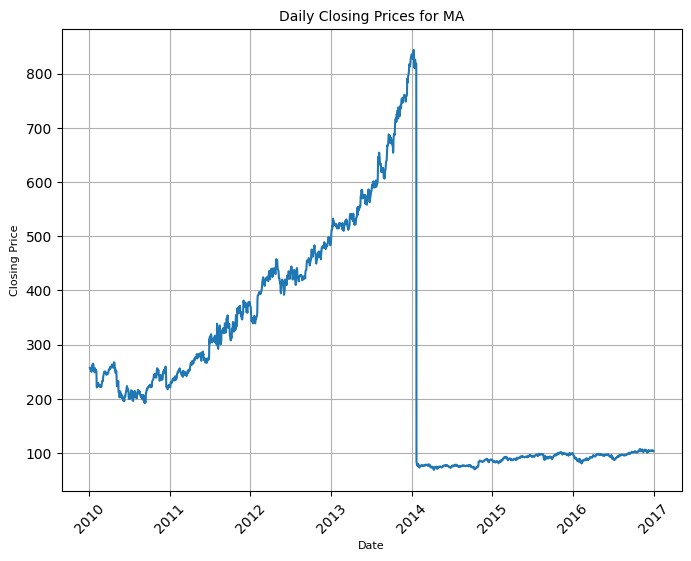

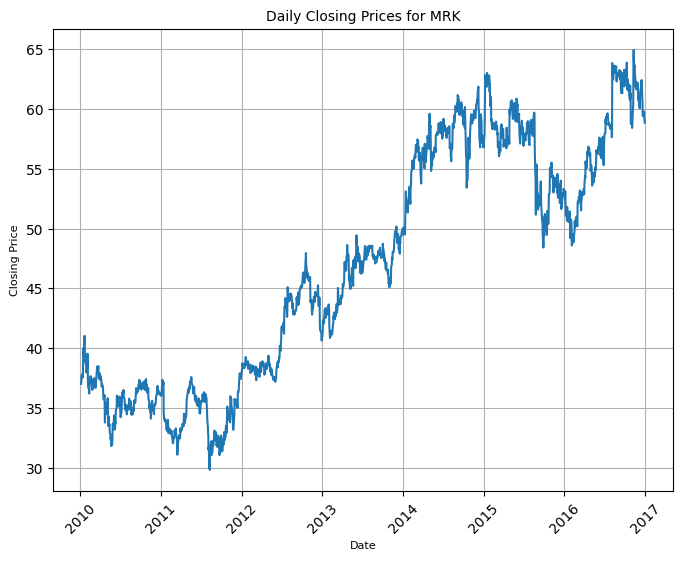

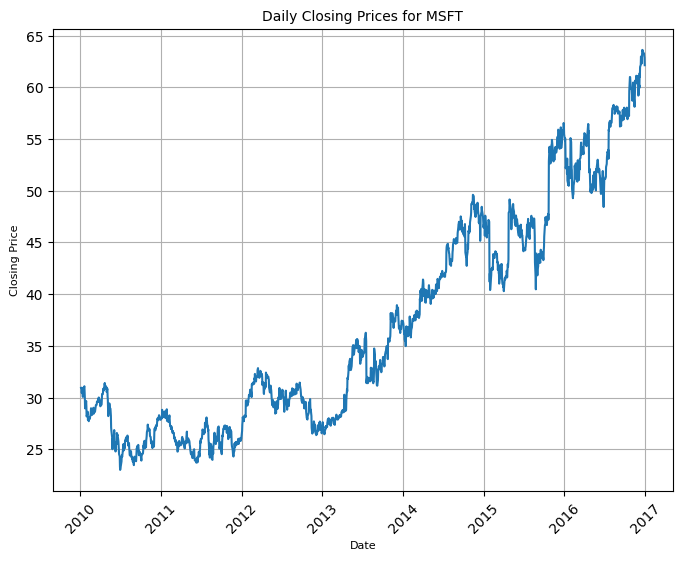

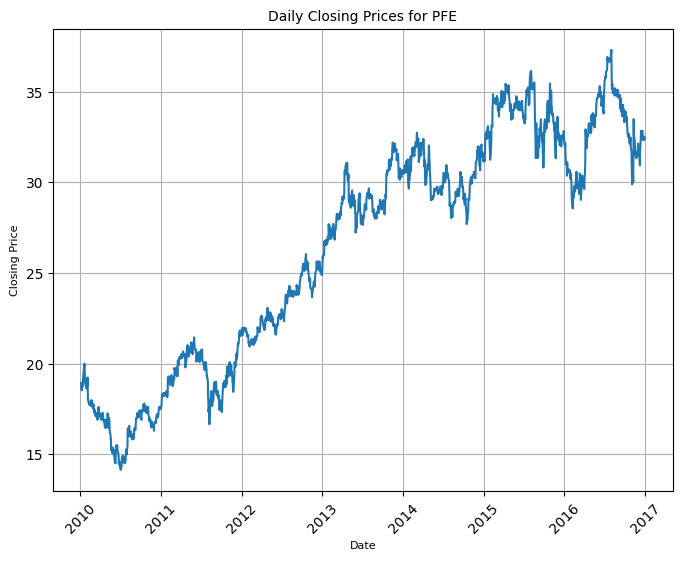

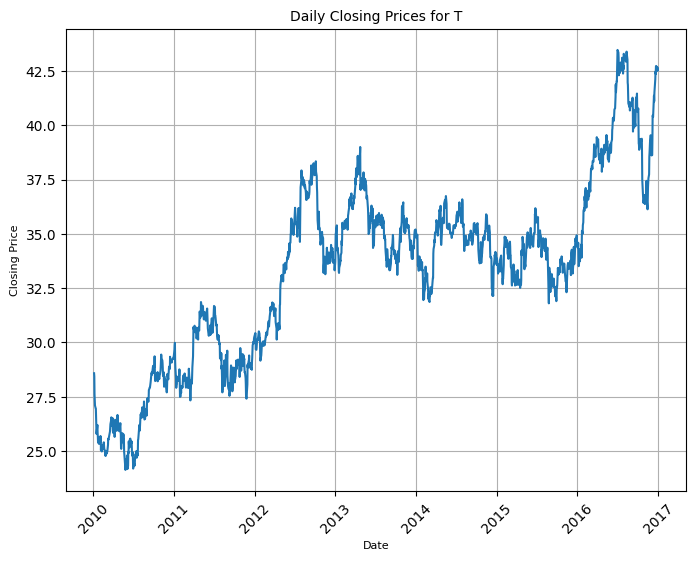

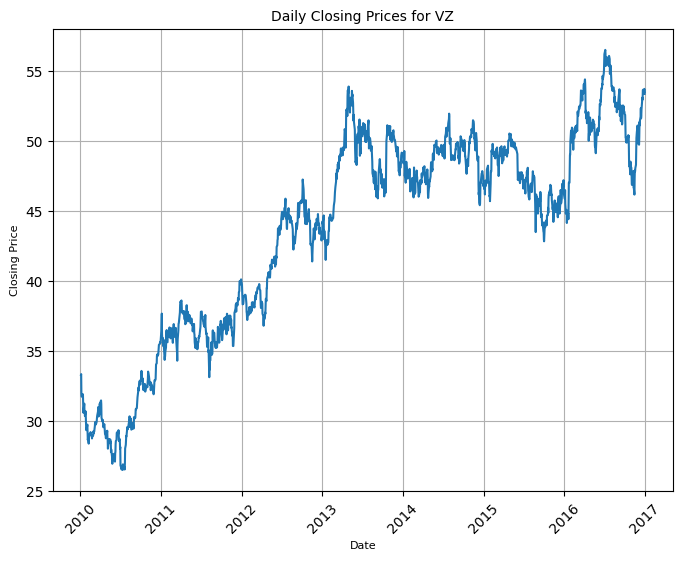

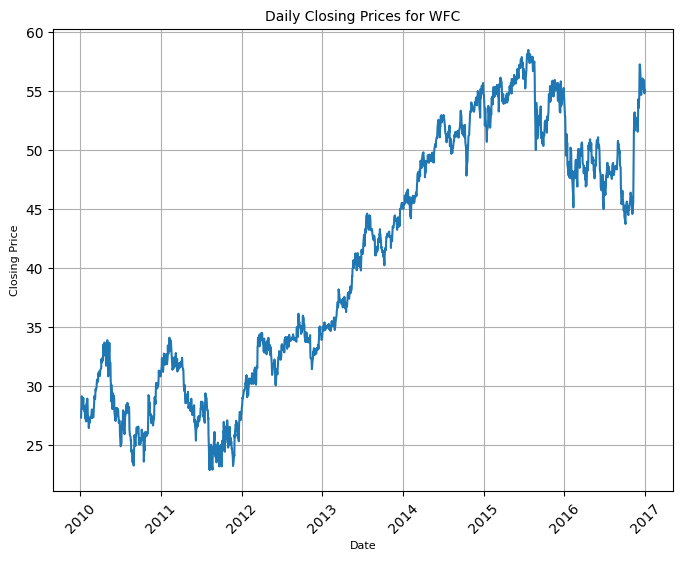

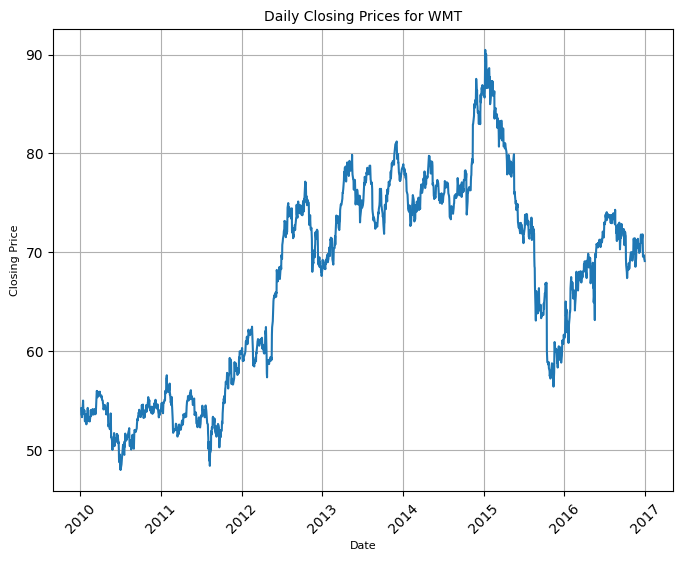

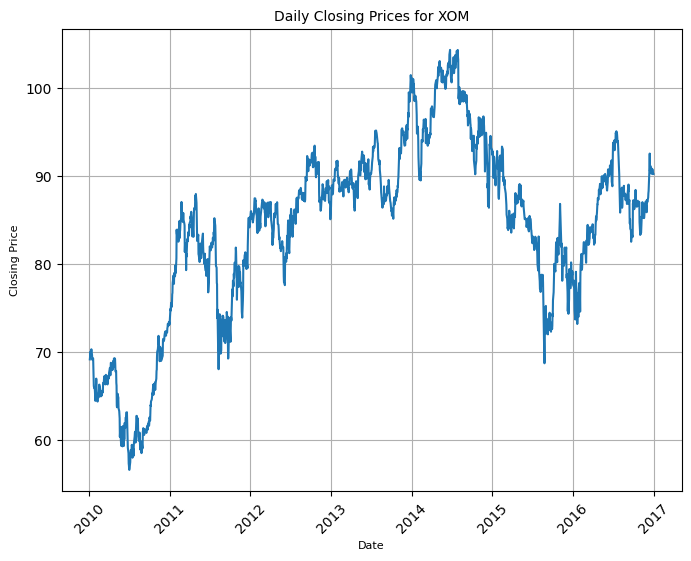

In [87]:
filtered_df = df[df['symbol'].isin(importantCompanies)]
groups = filtered_df.groupby('symbol')
# Plot each company's time series in a separate figure
for symbol, group in groups:
    plt.figure(figsize=(8, 6))
    plt.plot(group['date'], group['close'], linestyle='-', label=symbol, markersize = 0.1)

    # Add titles and labels
    plt.title(f'Daily Closing Prices for {symbol}', fontsize=10)
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Closing Price', fontsize=8)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot for the current company
    plt.grid(True)
    plt.show()

# Plot each company's time series in a separate figure



###**Part b**

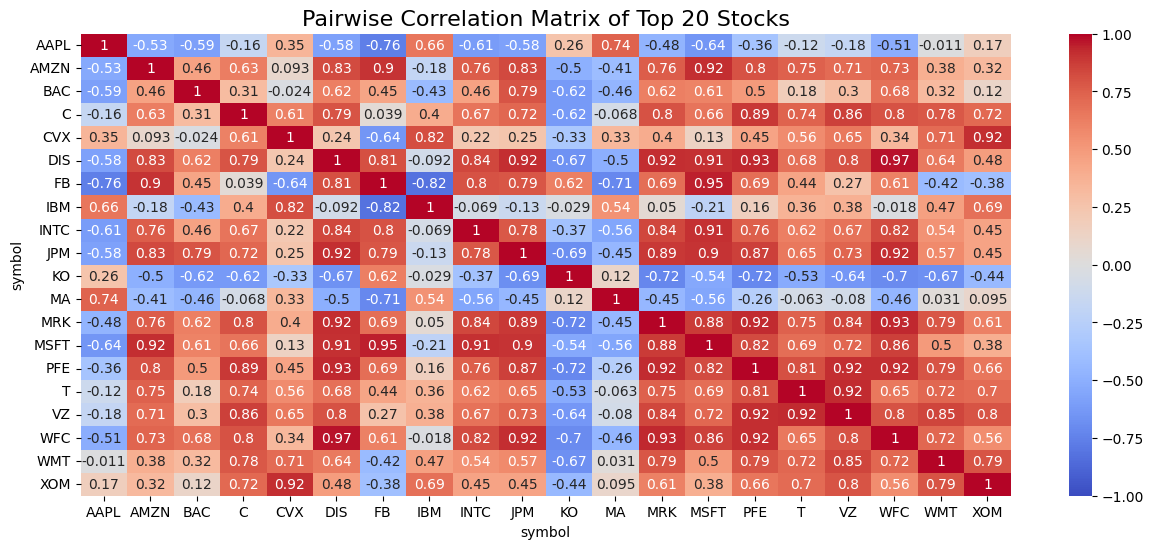

In [88]:
#Pivoting the dataframe based on date and symbol over close values
pivot_df = filtered_df.pivot(index='date', columns='symbol', values='close')

#Creating the correlation matrix
correlation_matrix = pivot_df.corr()

#Plotting the correlation matrix
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise Correlation Matrix of Top 20 Stocks', fontsize=16)
plt.show()

### **Part c**

In [89]:
correlation_pairs = correlation_matrix.unstack().sort_values(ascending=False)

correlation_pairs = correlation_pairs[correlation_pairs != 1]
unique_correlation_pairs = correlation_pairs[correlation_pairs.index.map(lambda x: x[0] < x[1])]
# Step 3: Find the most correlated pair
most_correlated = unique_correlation_pairs.head(3)
least_correlated = unique_correlation_pairs.tail(3)

# Display the most and least correlated pairs
print(f"Most Correlated Pairs: {most_correlated}")
print(f"Least Correlated Pairs: {least_correlated}")

Most Correlated Pairs: symbol  symbol
DIS     WFC       0.970308
FB      MSFT      0.946790
MRK     WFC       0.934662
dtype: float64
Least Correlated Pairs: symbol  symbol
KO      MRK      -0.721930
AAPL    FB       -0.761233
FB      IBM      -0.820702
dtype: float64


Explanations for part c: Maybe the Companies are not in correlated sectors or maybe the companies are in same sectors and are competetors of each other


### **Part d**

In [90]:
securities_df = pd.read_csv('securities.csv')

def get_sectors_for_pair(pair, securities_df):
    symbol1, symbol2 = pair
    sector1 = securities_df[securities_df['Ticker symbol'] == symbol1]['GICS Sector'].values[0]
    sector2 = securities_df[securities_df['Ticker symbol'] == symbol2]['GICS Sector'].values[0]
    return sector1, sector2

most_correlated_symbols = most_correlated.index
least_correlated_symbols = least_correlated.index

# Step 3: Get the sectors for the most correlated pairs
print("\nMost Correlated Pairs and their Sectors:")
for pair in most_correlated_symbols:
    sector1, sector2 = get_sectors_for_pair(pair, securities_df)
    print(f"{pair[0]} and {pair[1]}: {sector1} and {sector2}")

# Step 4: Get the sectors for the least correlated pairs
print("\nLeast Correlated Pairs and their Sectors:")
for pair in least_correlated_symbols:
    sector1, sector2 = get_sectors_for_pair(pair, securities_df)
    print(f"{pair[0]} and {pair[1]}: {sector1} and {sector2}")


Most Correlated Pairs and their Sectors:
DIS and WFC: Consumer Discretionary and Financials
FB and MSFT: Information Technology and Information Technology
MRK and WFC: Health Care and Financials

Least Correlated Pairs and their Sectors:
KO and MRK: Consumer Staples and Health Care
AAPL and FB: Information Technology and Information Technology
FB and IBM: Information Technology and Information Technology


Insights from part d: In highly correlated pairs I see that two of the pairs include a bank which may be due to some kind of loans/investement and in the least correlated pairs I see same sector companies which could mean that there was some kind of fight going on in the market between these companies and they were competing with each other

## **Q5: Distribution of Daily Price Movements  (10 Points)**
Plot the distributions of frequency of daily price movements according to your statistic.   What type of classical distribution does this look like, and are there any surprising deviations from the theoretical distribution?

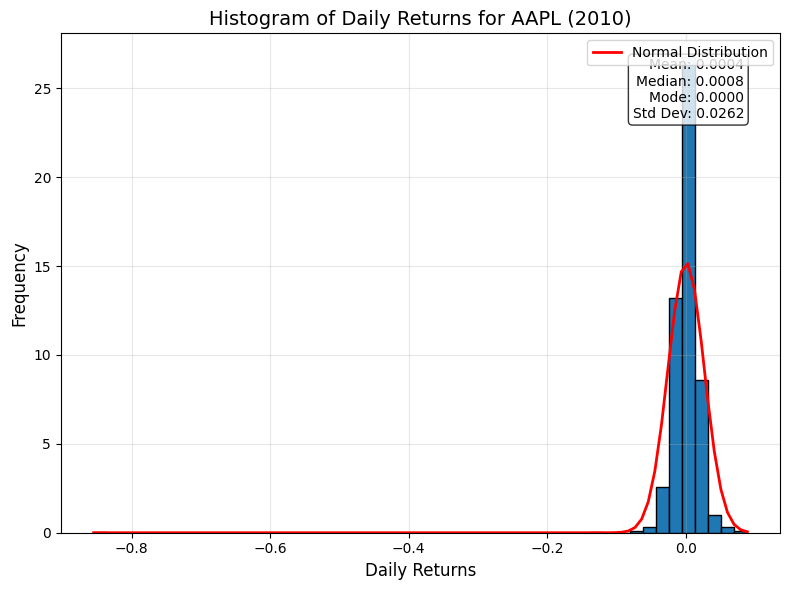

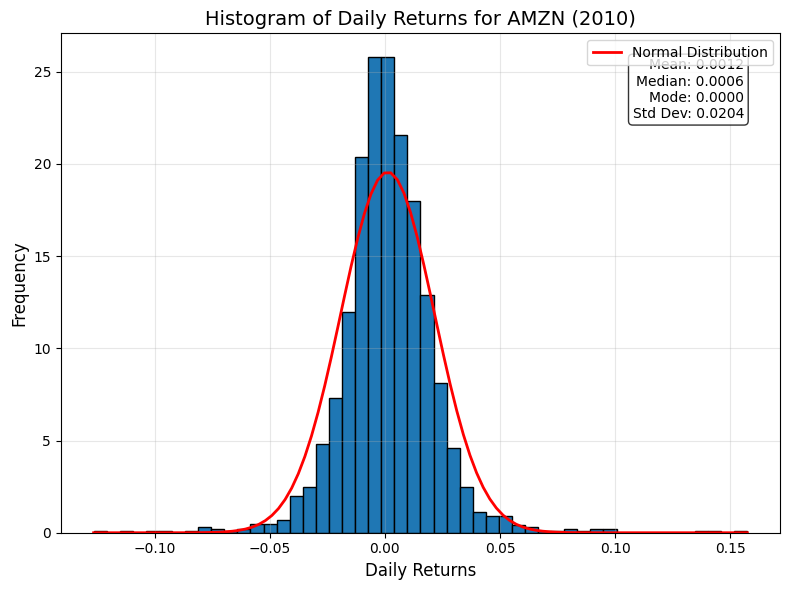

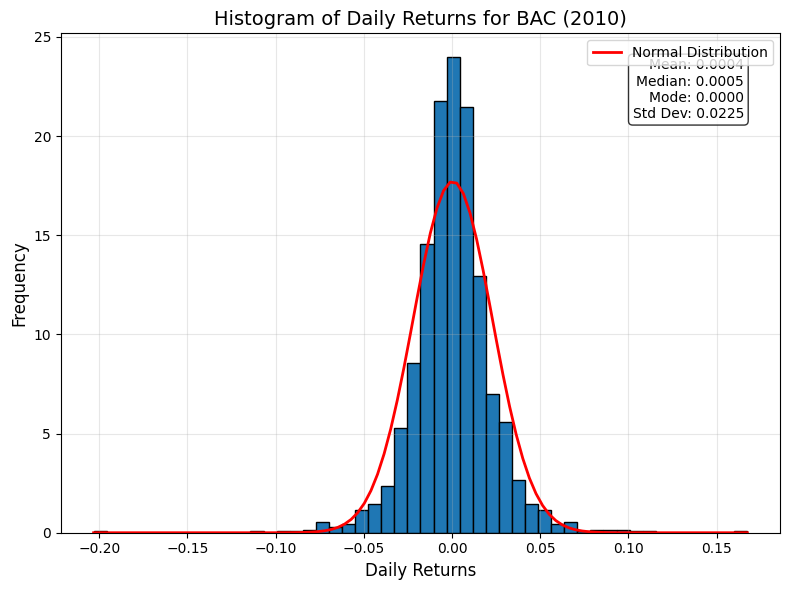

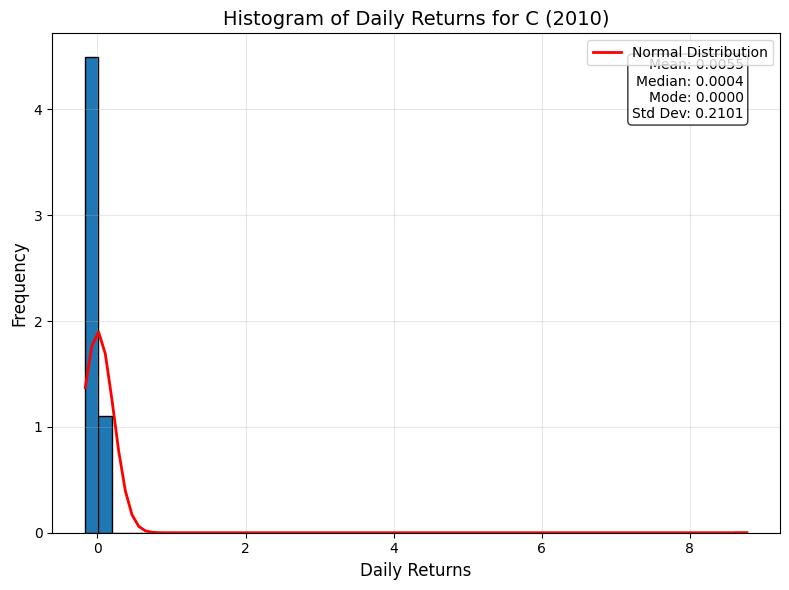

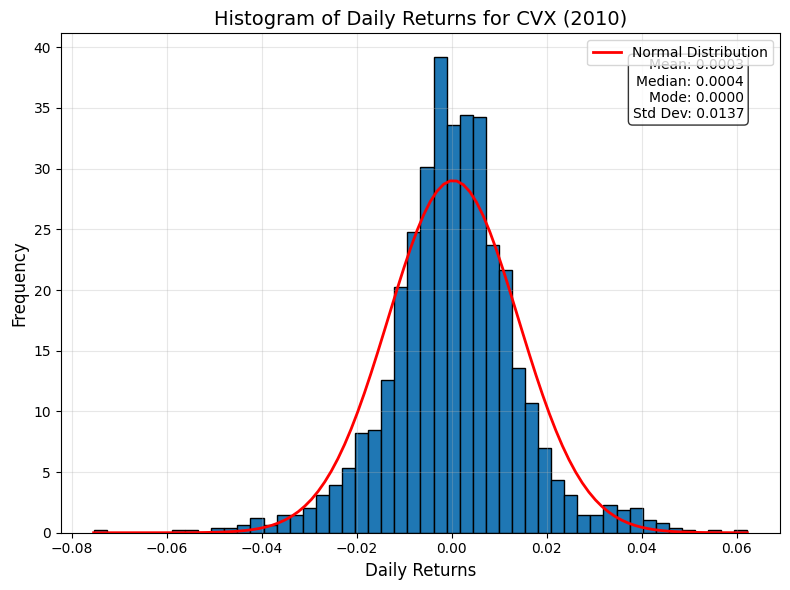

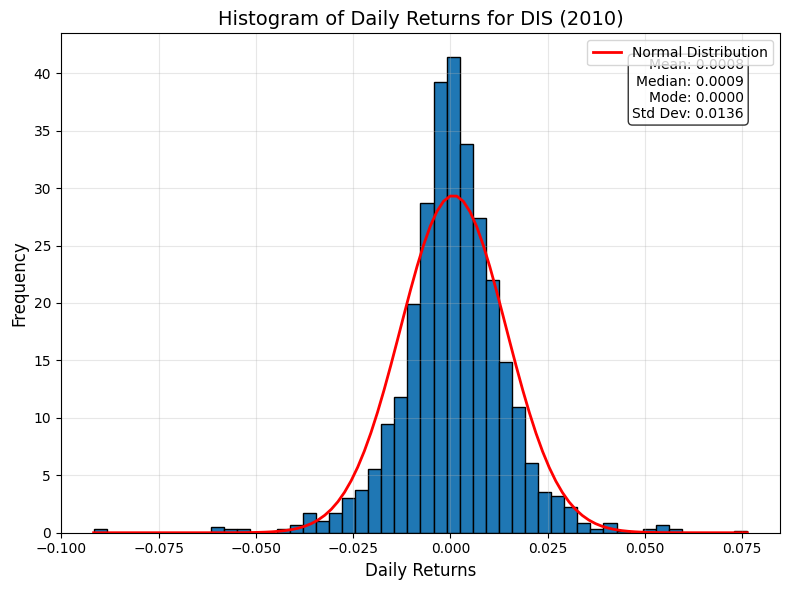

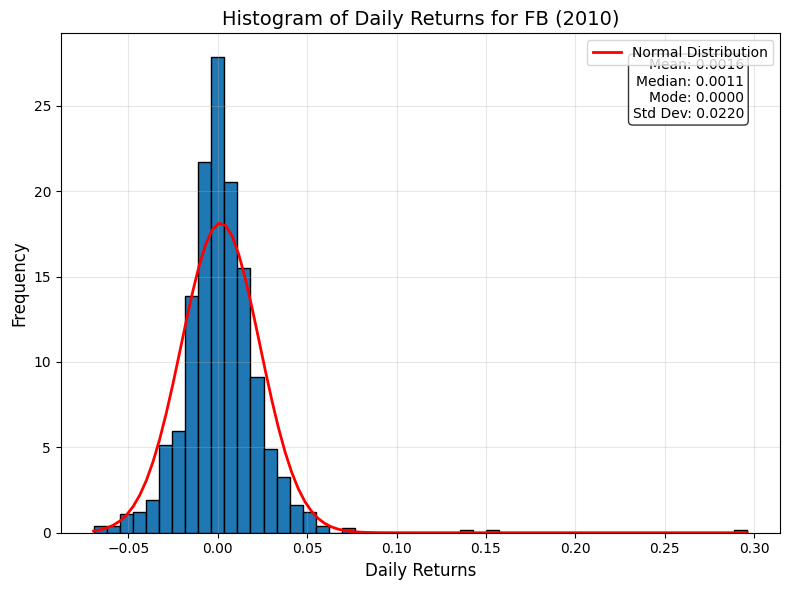

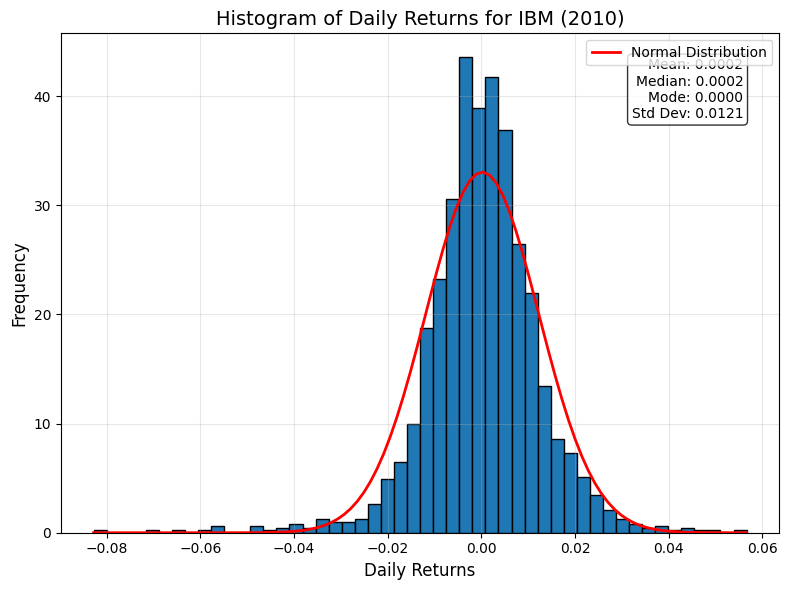

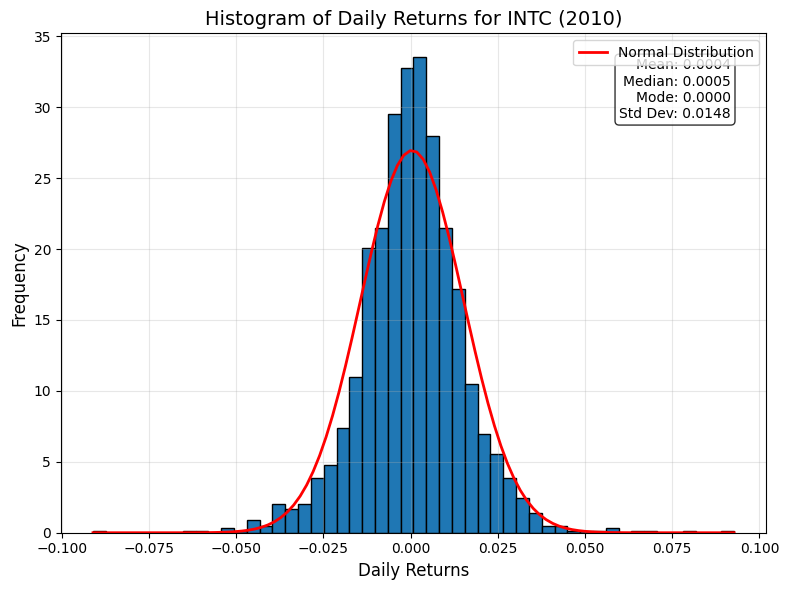

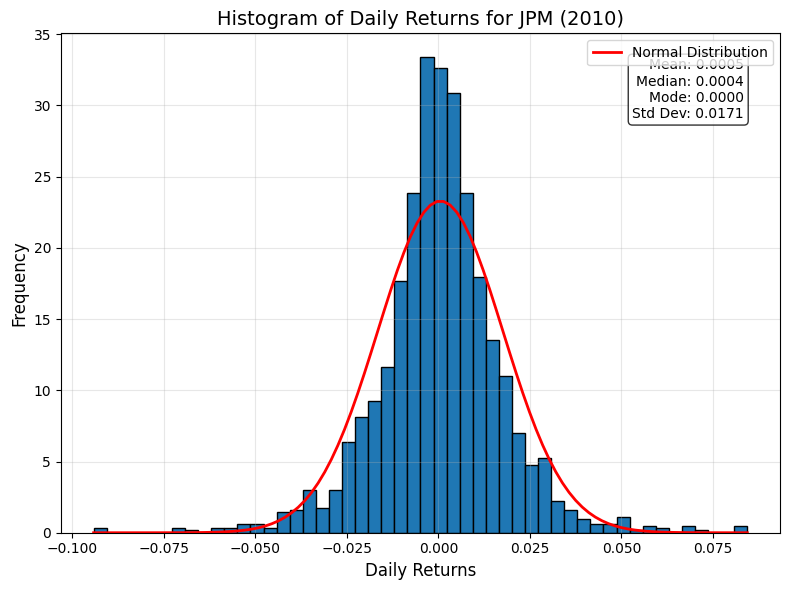

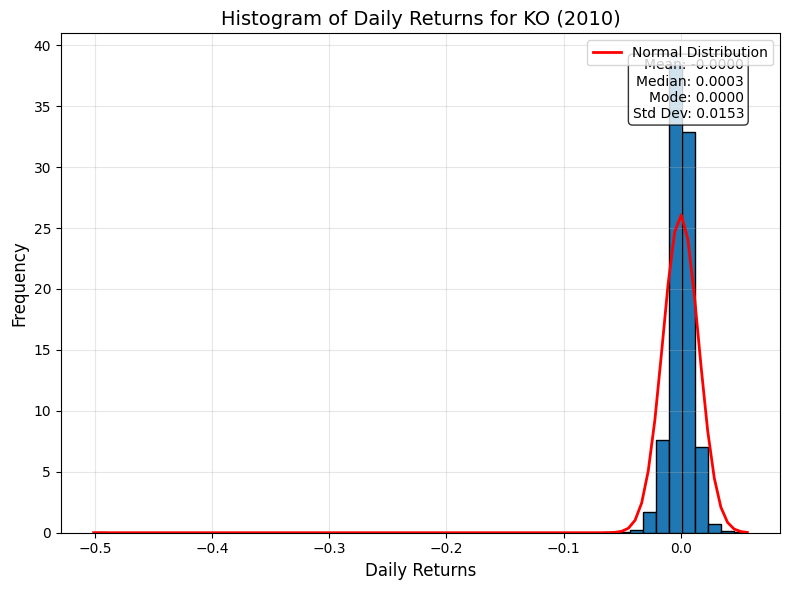

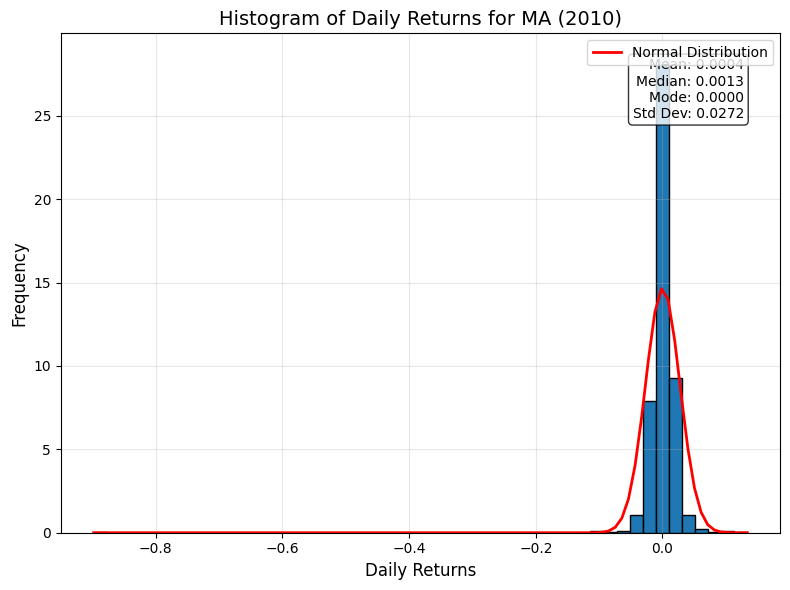

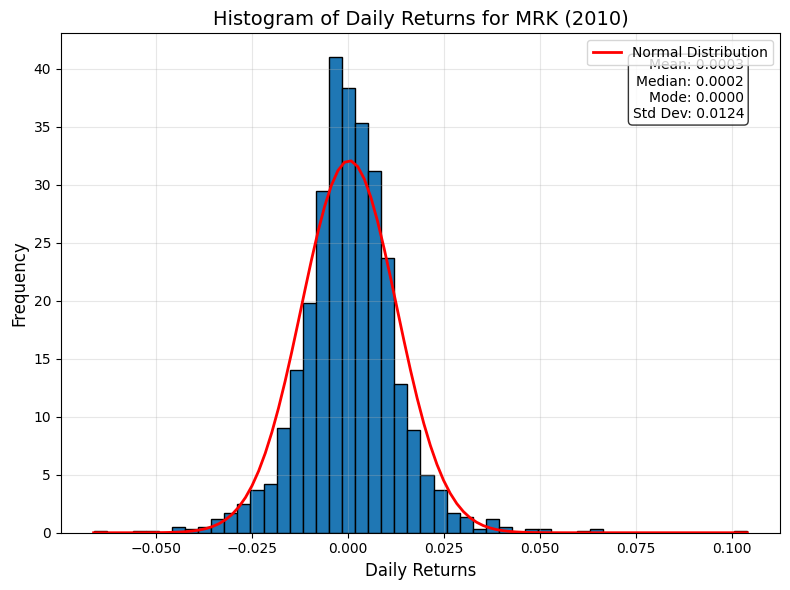

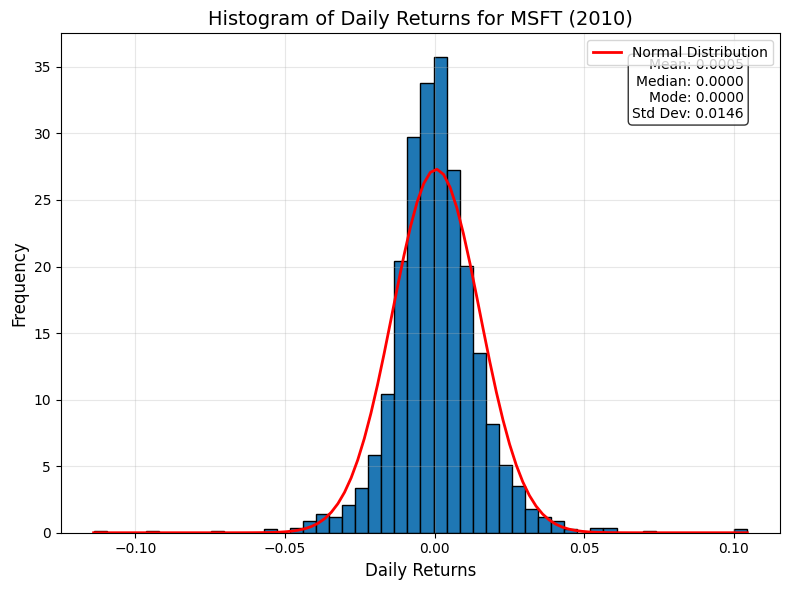

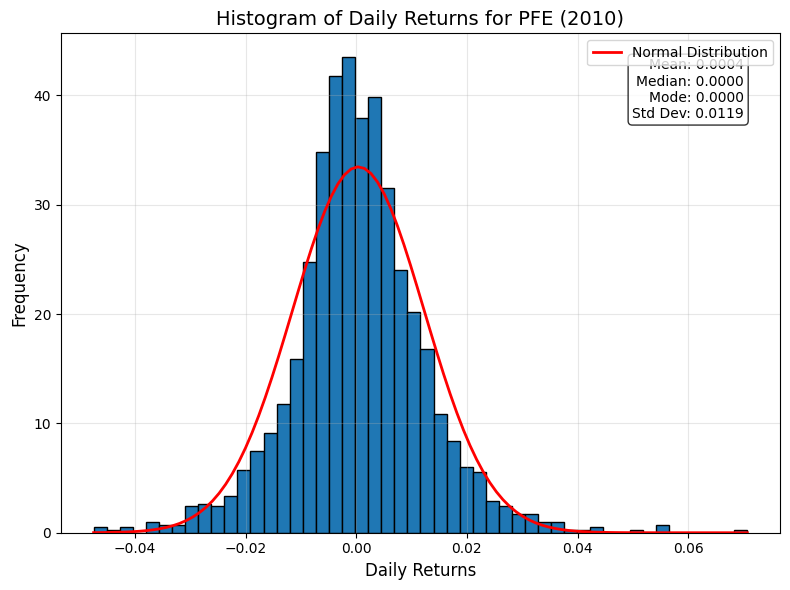

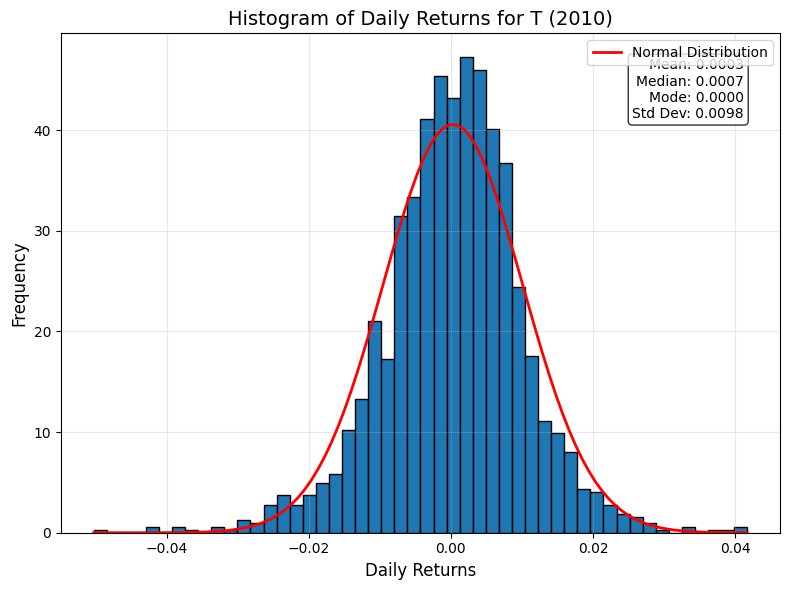

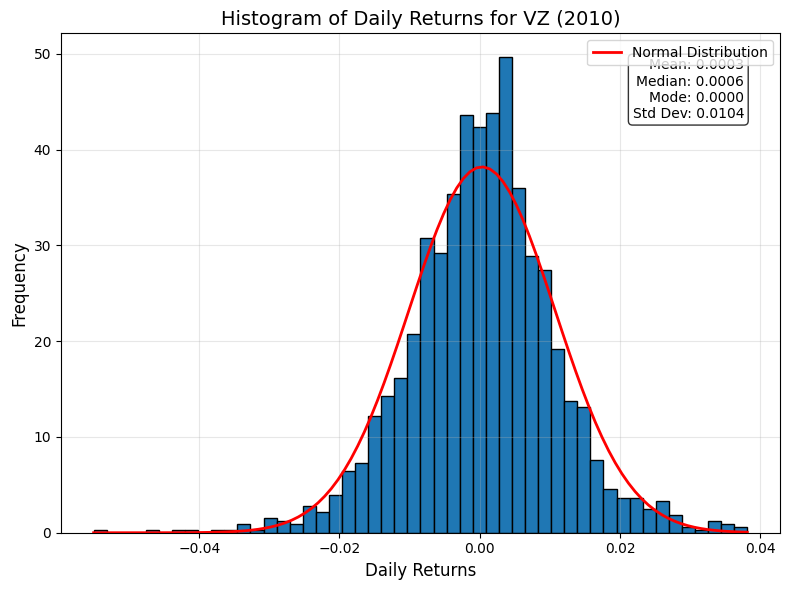

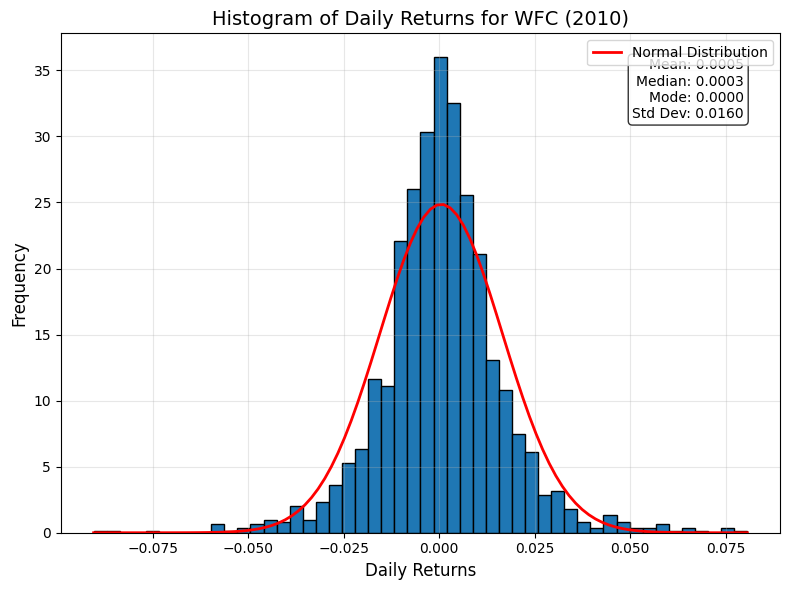

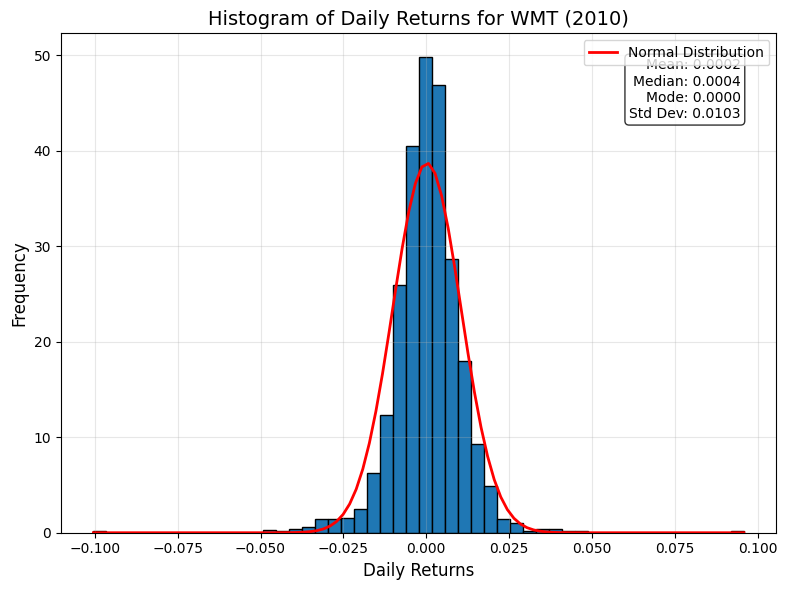

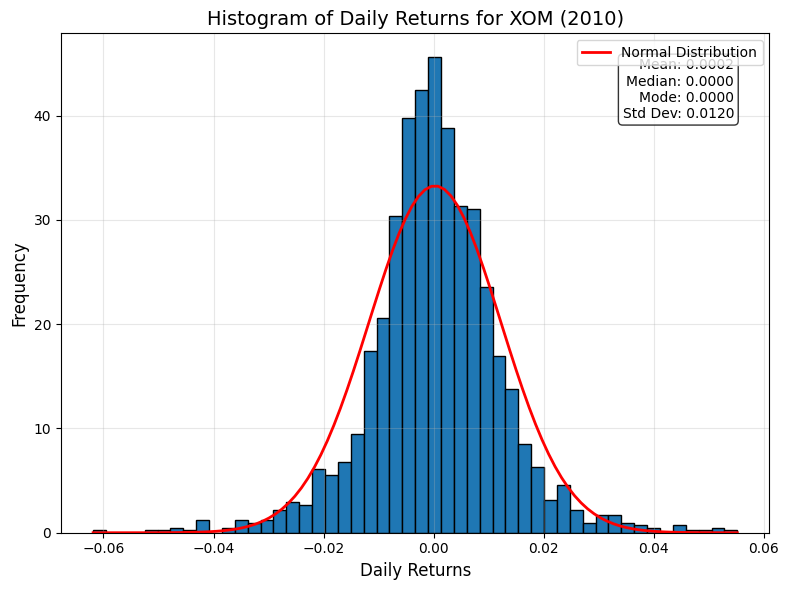

In [91]:
from scipy import stats

filtered_df = filtered_df[(filtered_df['date'] >= start_date) & (filtered_df['date'] <= end_date)]

# Calculate daily returns within the filtered date range
filtered_df['daily_returns'] = filtered_df.groupby('symbol')['close'].pct_change()

# Remove rows where daily_returns is NaN (due to pct_change on the first entry of each group)
filtered_df = filtered_df.dropna(subset=['daily_returns'])

# Group the filtered data by 'symbol'
groups = filtered_df.groupby('symbol')

# Plot histogram and distribution line for each company in a separate figure
for symbol, group in groups:
    plt.figure(figsize=(8, 6))  # Adjust figure size for better readability

    # Create histogram of daily returns
    hist, bins, _ = plt.hist(group['daily_returns'], bins=50, edgecolor='black', density=True)

    # Calculate mean, median, and mode
    mean_return = group['daily_returns'].mean()
    median_return = group['daily_returns'].median()
    mode_return = group['daily_returns'].mode()[0]

    # Add distribution line
    x = np.linspace(bins[0], bins[-1], 100)
    plt.plot(x, stats.norm.pdf(x, mean_return, group['daily_returns'].std()), color='r', linewidth=2, label='Normal Distribution')

    # Add titles and labels
    plt.title(f'Histogram of Daily Returns for {symbol} (2010)', fontsize=14)
    plt.xlabel('Daily Returns', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Add a grid and legend
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)

    # Add text box with summary statistics
    stats_text = f'Mean: {mean_return:.4f}\nMedian: {median_return:.4f}\nMode: {mode_return:.4f}\nStd Dev: {group["daily_returns"].std():.4f}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Display the histogram and distribution line for the current symbol
    plt.tight_layout()
    plt.show()

Answer for Q5: From the above graphs we can see that most of the companies's daily price movement is 0 % while there are some incidents where there has been a significant amount of change in the price which can indicate that there was a stock split

## **Q6: Exploratory Data Analysis (15 Points)**
Create three plots of your own using the dataset that you think reveal something very interesting. Explain what it is, and anything else you learned from your exploration.

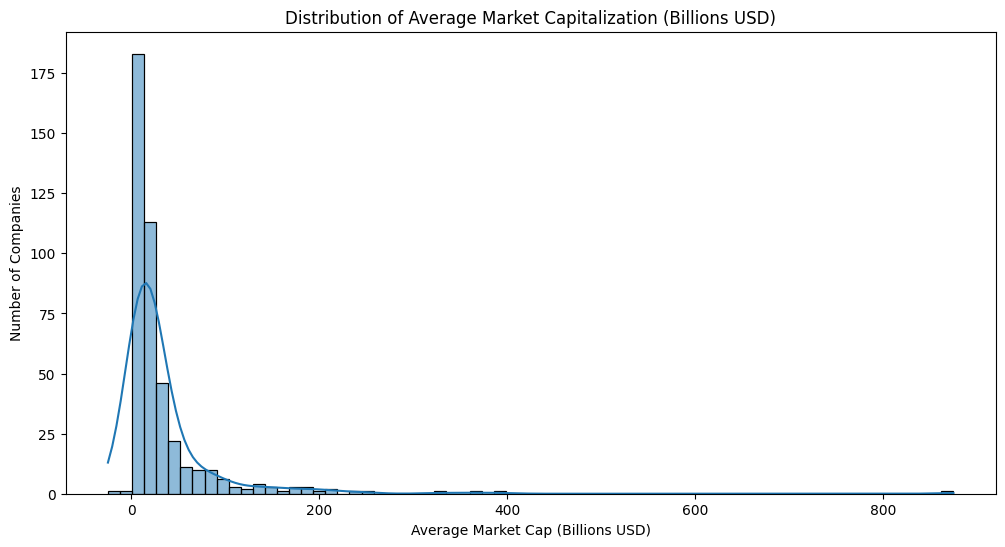

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(avg_market_cap['Avg_Market_Cap_Billion'], bins=70, kde=True)
plt.title('Distribution of Average Market Capitalization (Billions USD)')
plt.xlabel('Average Market Cap (Billions USD)')
plt.ylabel('Number of Companies')
plt.show()

We can deduce from the above graph that even in the top 500 companies there is quite a difference between the top 10-20 companies and the other companies in terms of market cap. The average is around 15-20 billion and other giants like apple and microsoft are at a much higher market cap

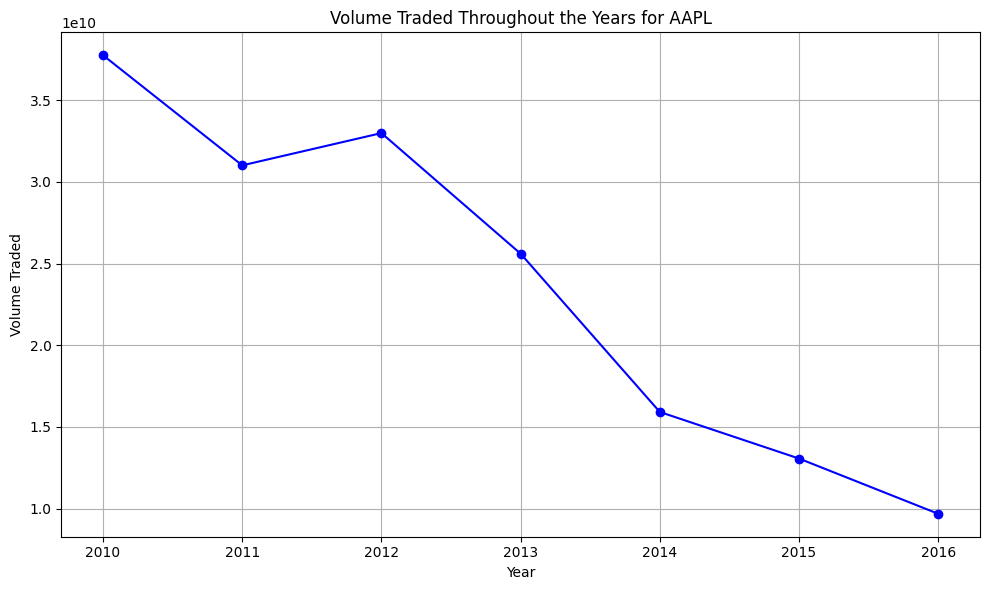

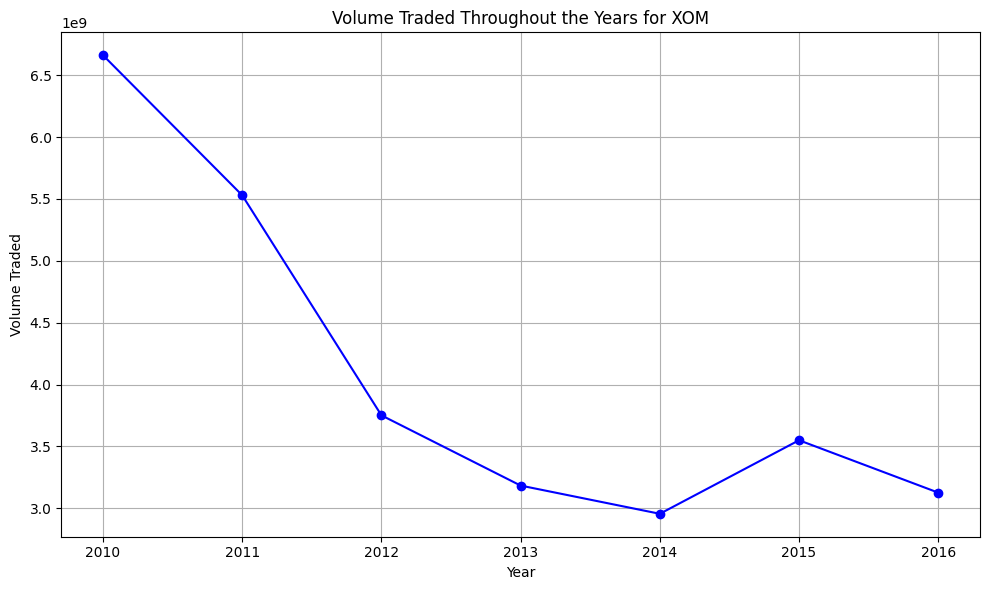

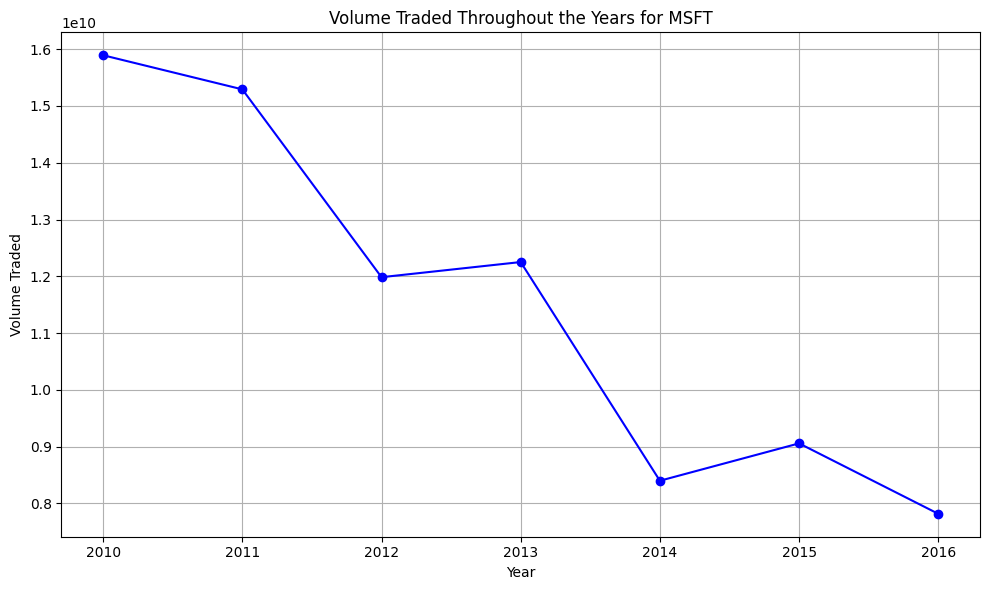

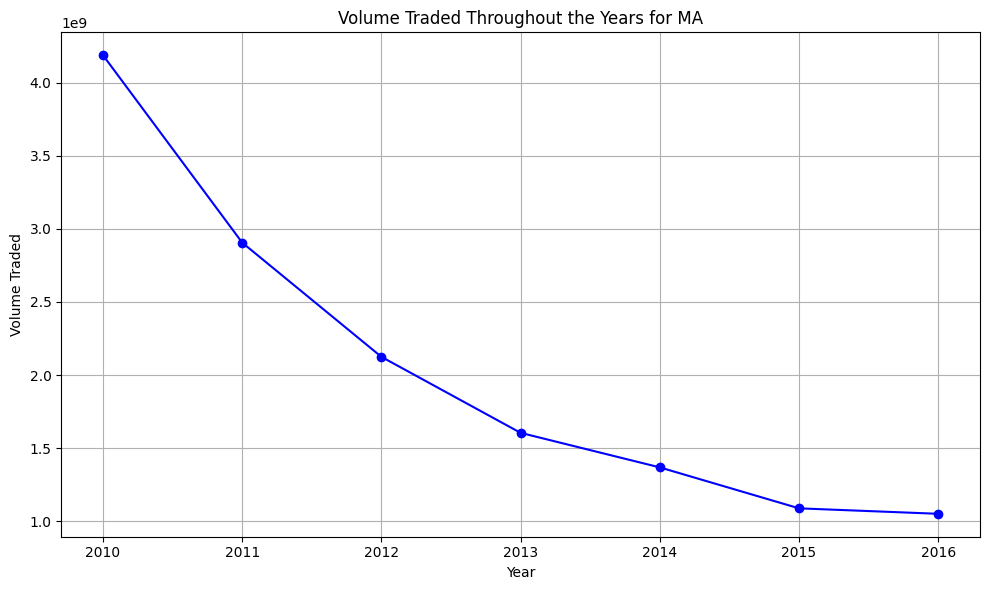

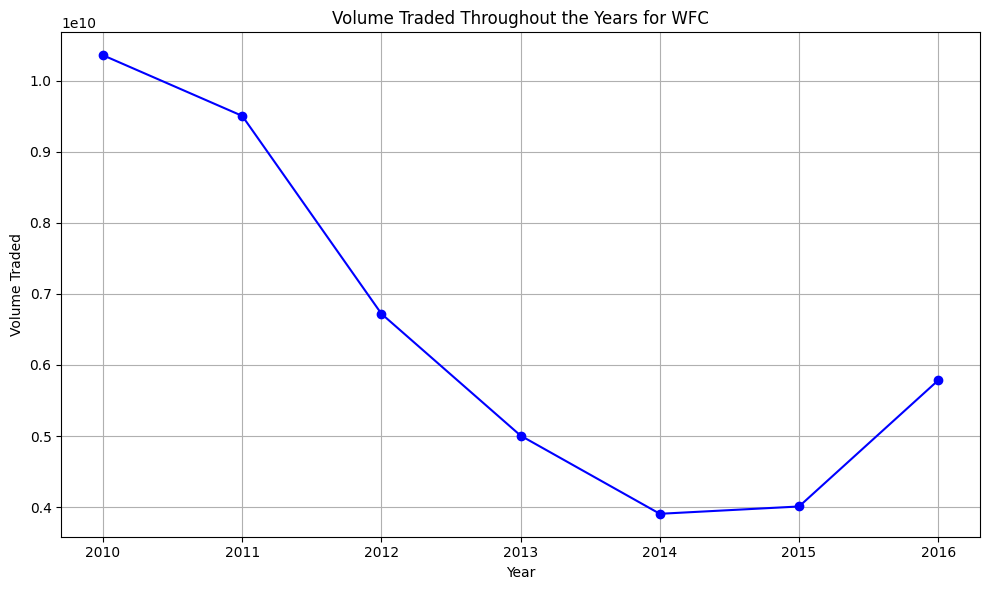

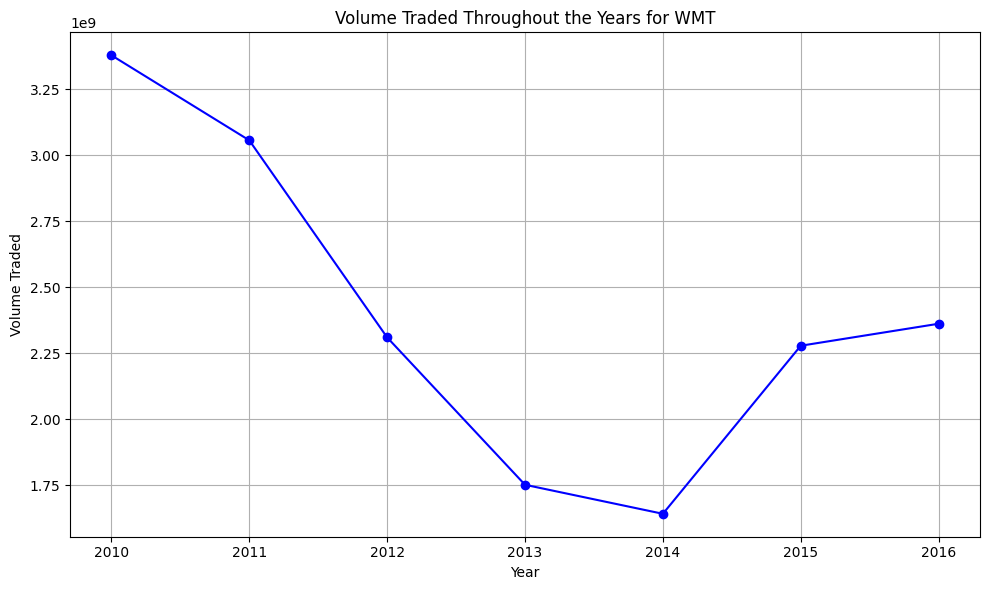

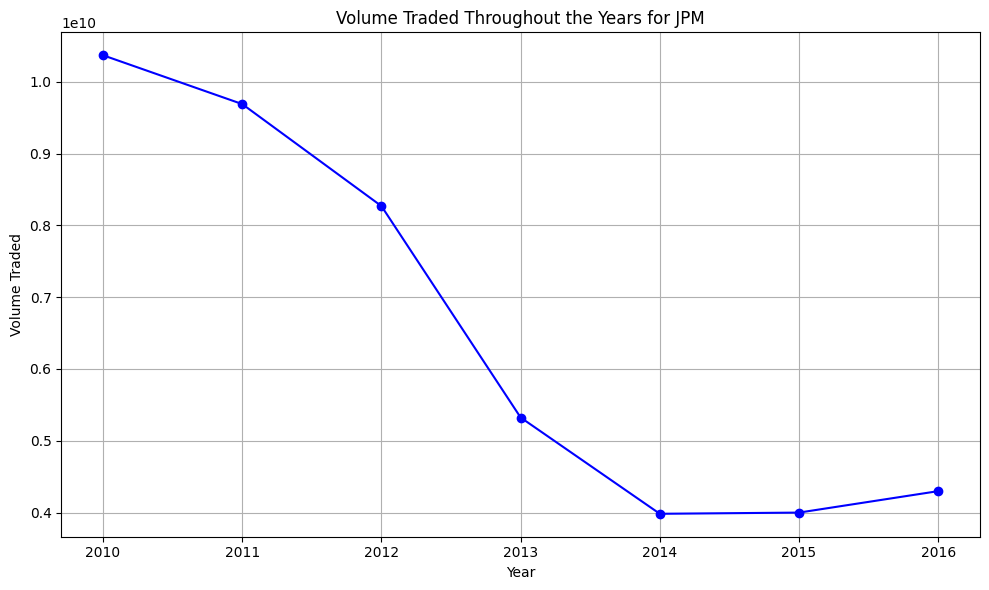

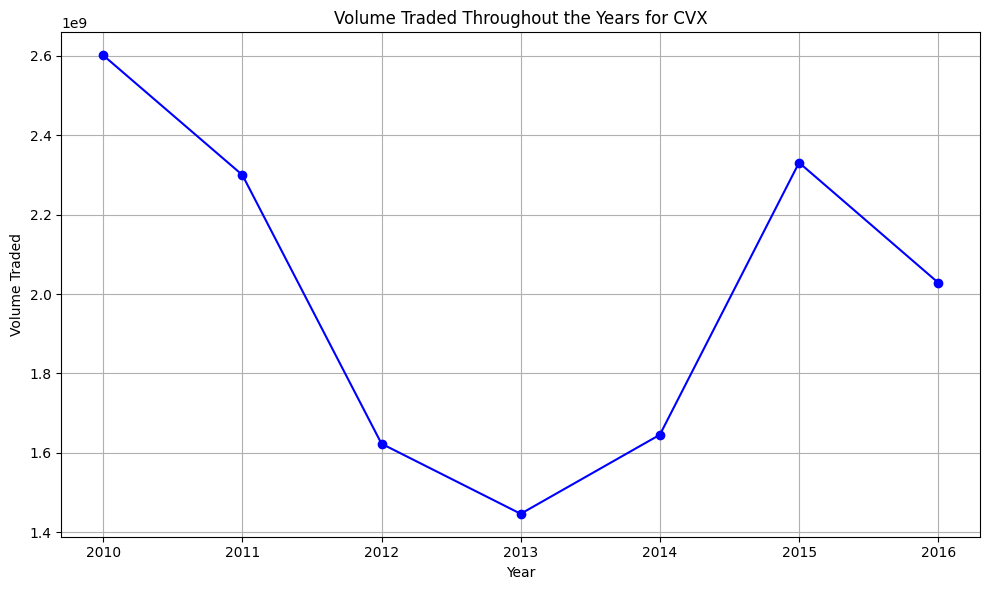

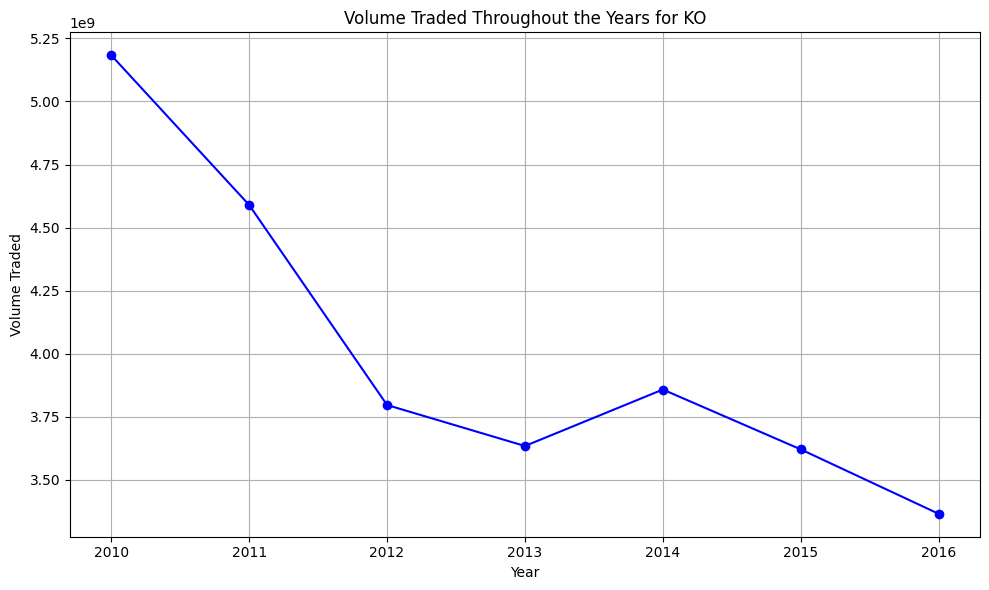

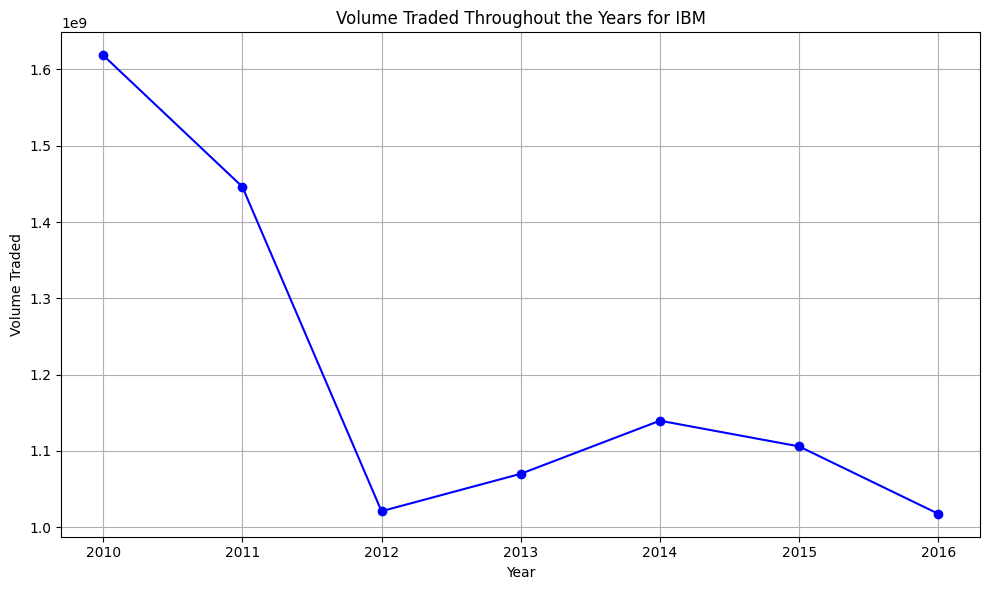

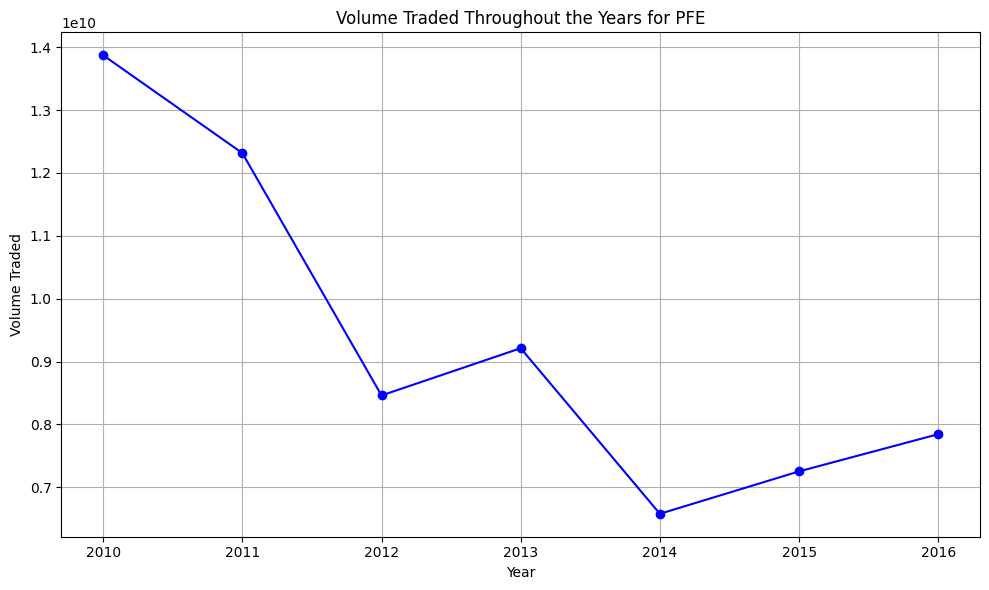

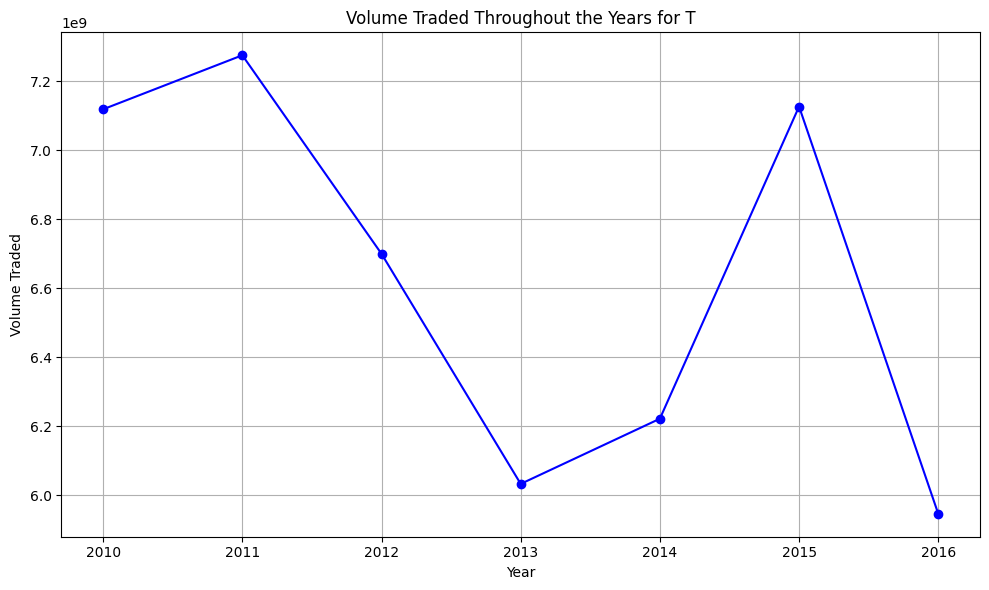

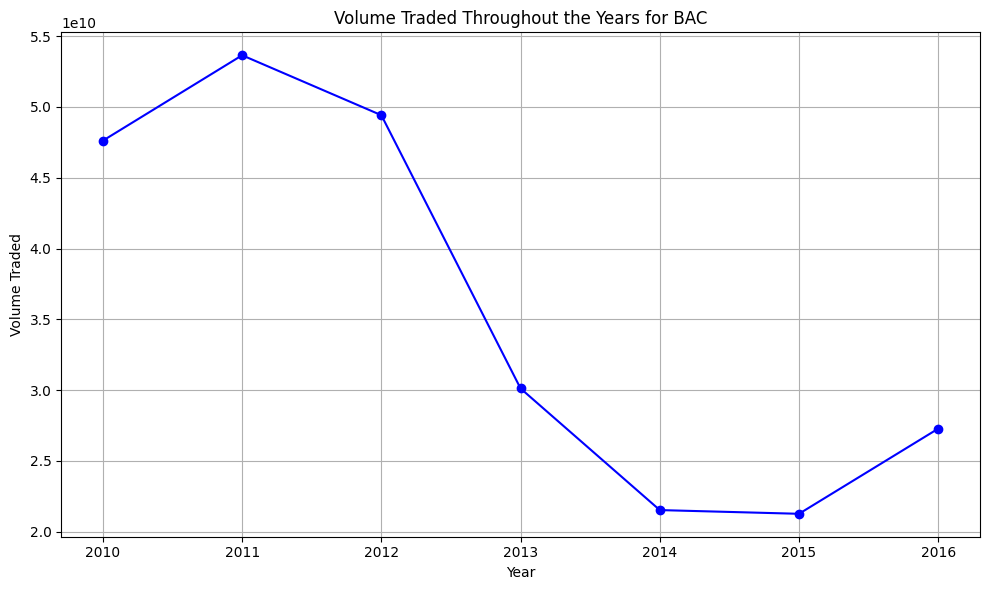

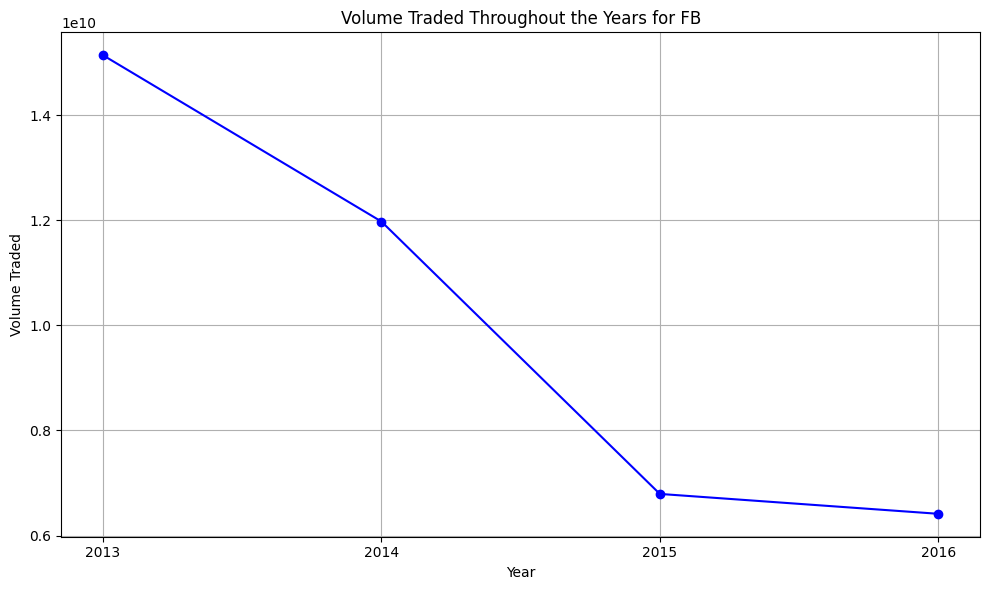

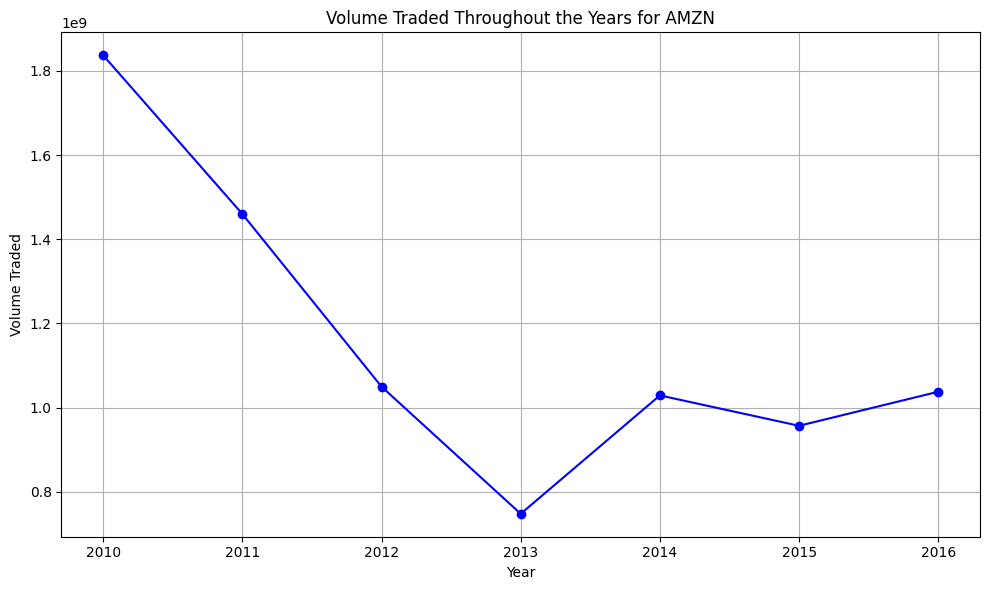

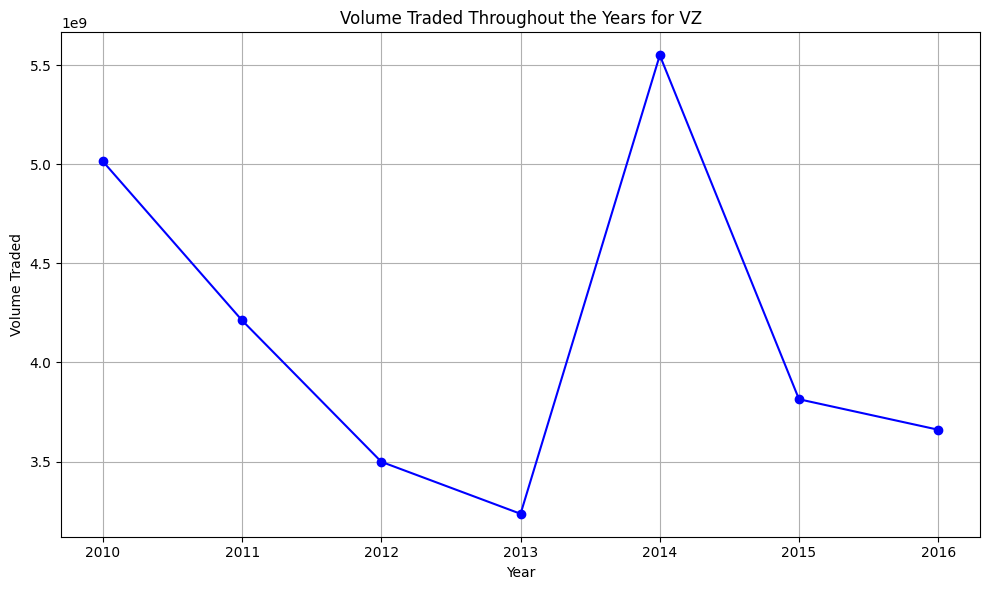

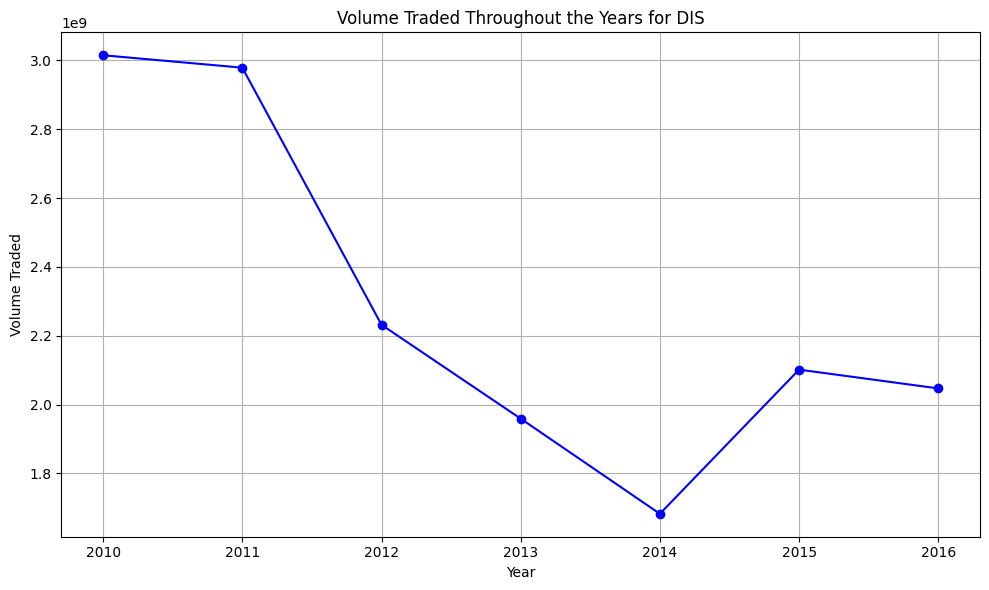

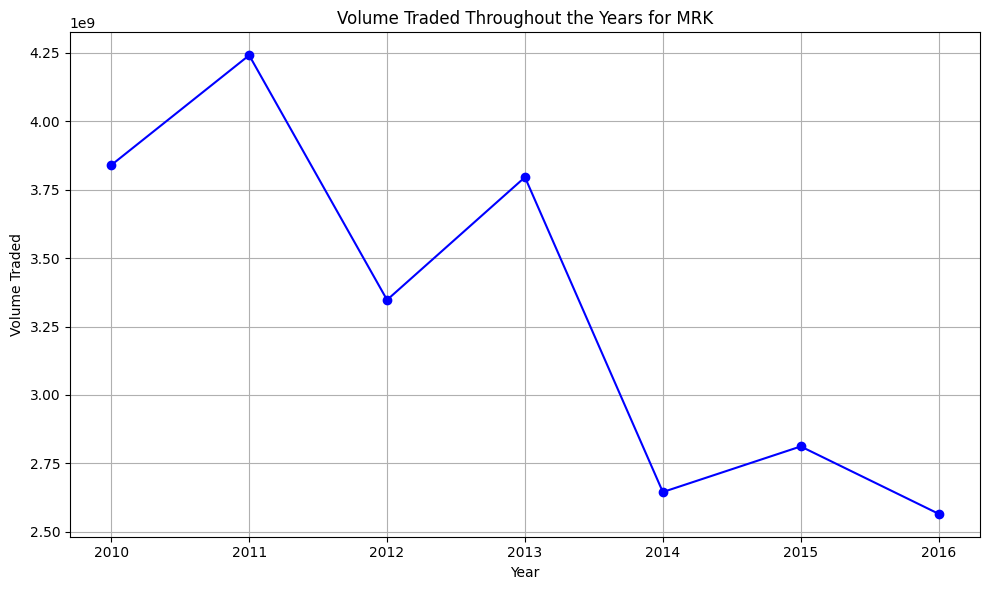

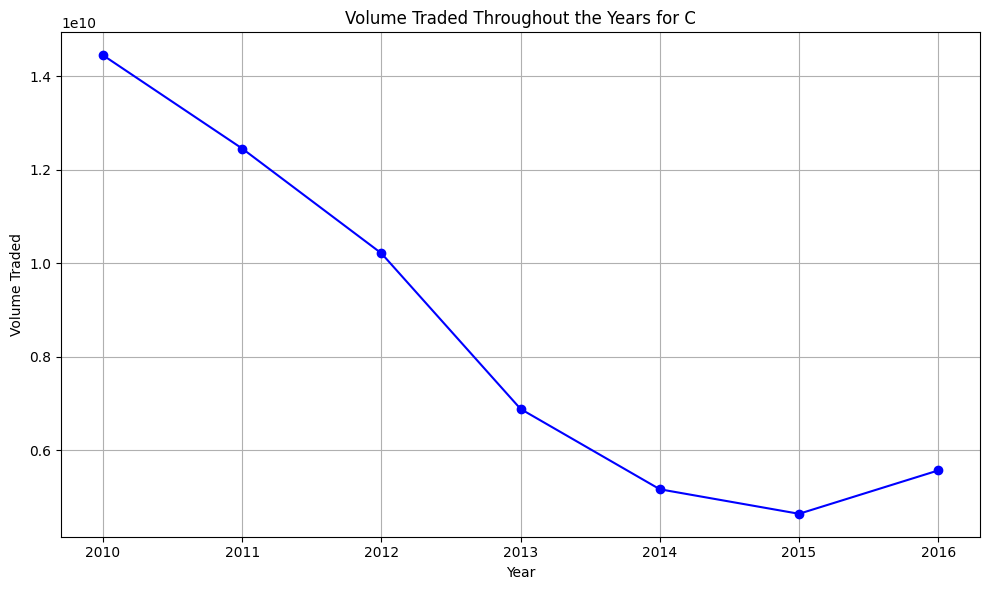

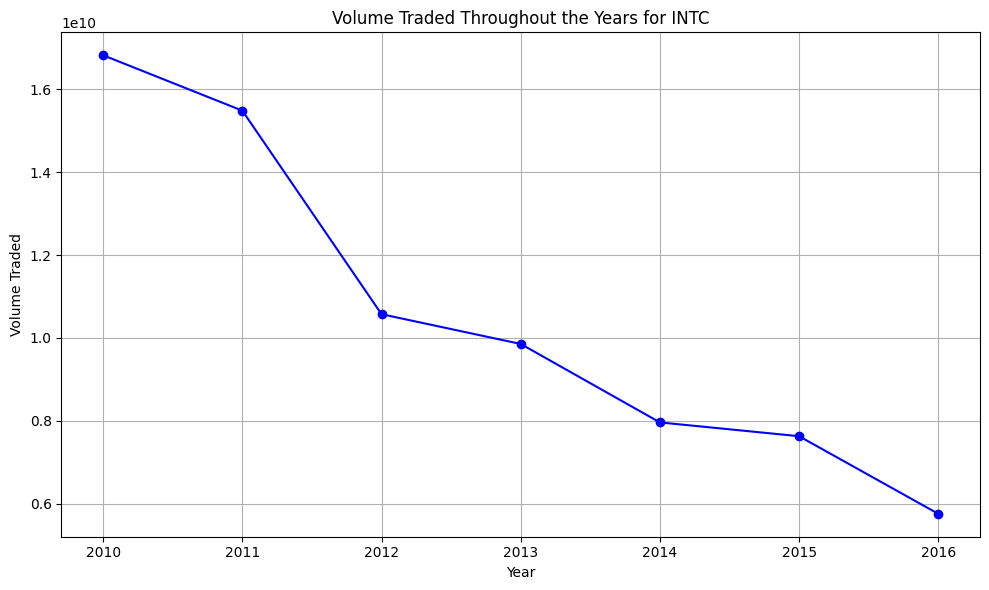

In [139]:
prices = pd.read_csv('prices.csv')
filtered_data = prices[prices['symbol'].isin(importantCompanies)]

filtered_data['date'] = pd.to_datetime(filtered_data['date'])
filtered_data['year'] = filtered_data['date'].dt.year

volume_by_year = filtered_data.groupby(['symbol', 'year'])['volume'].sum().reset_index()

for company in importantCompanies:
    # Filter data for the current company
    company_data = volume_by_year[volume_by_year['symbol'] == company]

    # Create a plot for each company
    plt.figure(figsize=(10, 6))
    plt.plot(company_data['year'], company_data['volume'], marker='o', color='b', linestyle='-', label=company)

    # Customize each plot
    plt.title(f'Volume Traded Throughout the Years for {company}')
    plt.xlabel('Year')
    plt.ylabel('Volume Traded')
    plt.grid(True)
    plt.xticks(company_data['year'].unique())  # Set year labels
    plt.tight_layout()

    # Show the plot for each company
    plt.show()


I have plotted daily volume traded over the course of the entire duration in the dataset. What I found is that the volume traded for each company in the top is decreasing and is potentially due to people holding on to the stock and eventually increasing the stock price due to demand

<Figure size 1400x700 with 0 Axes>

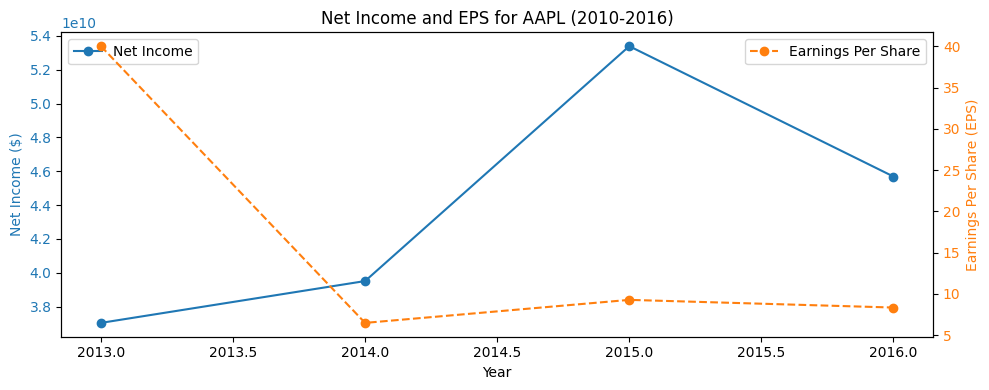

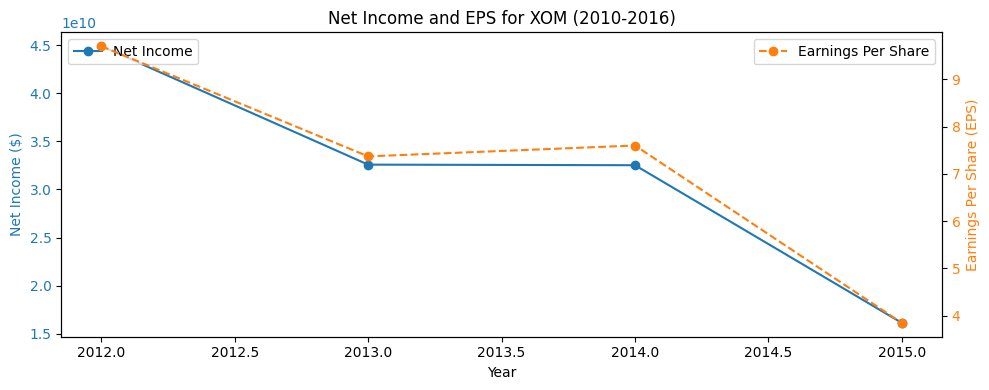

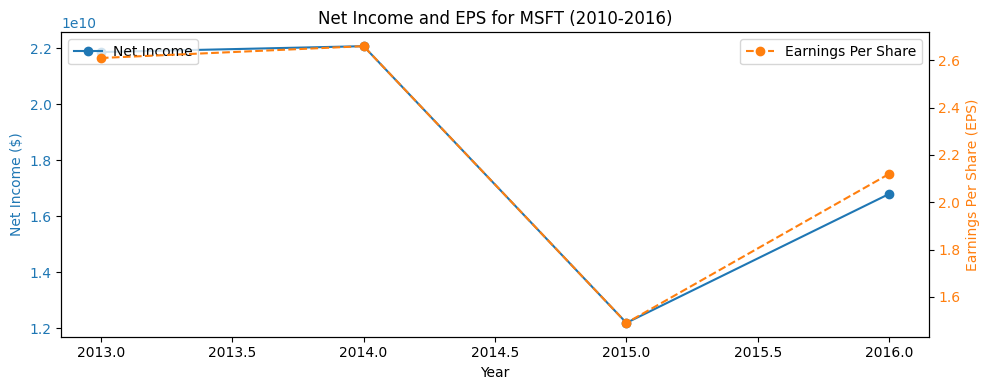

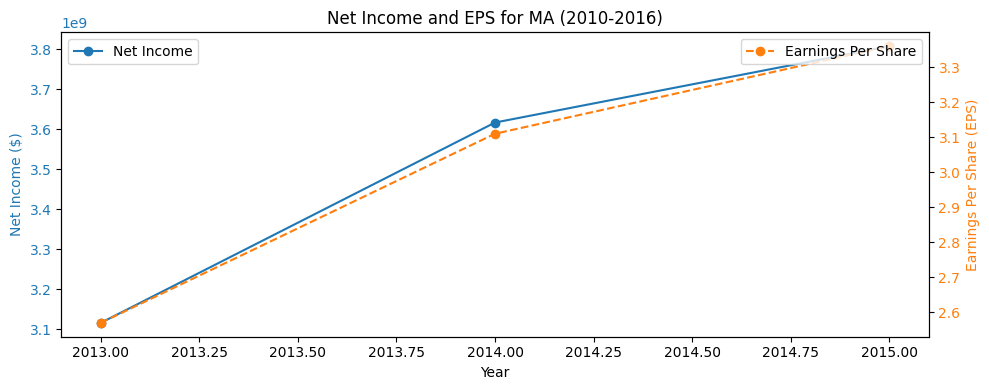

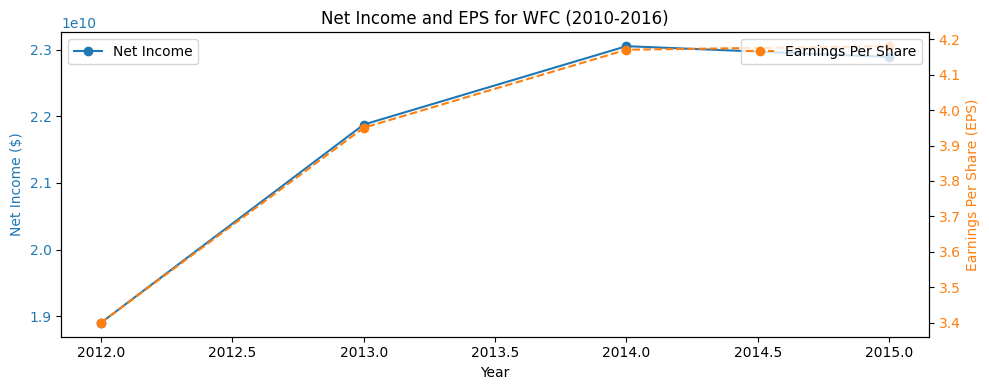

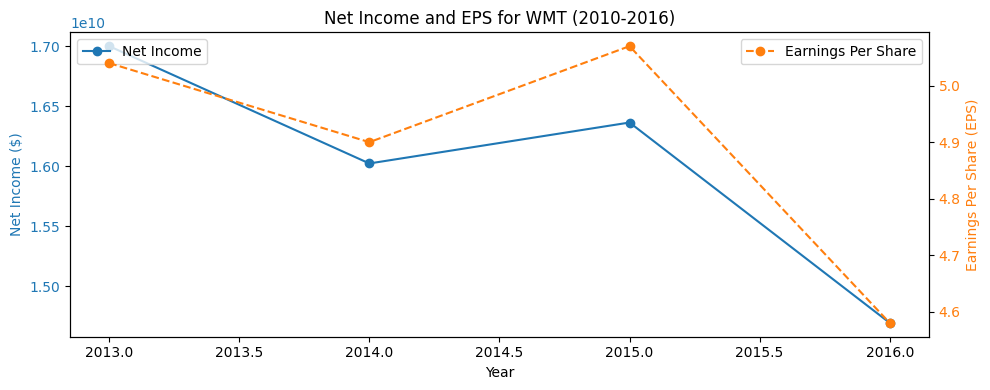

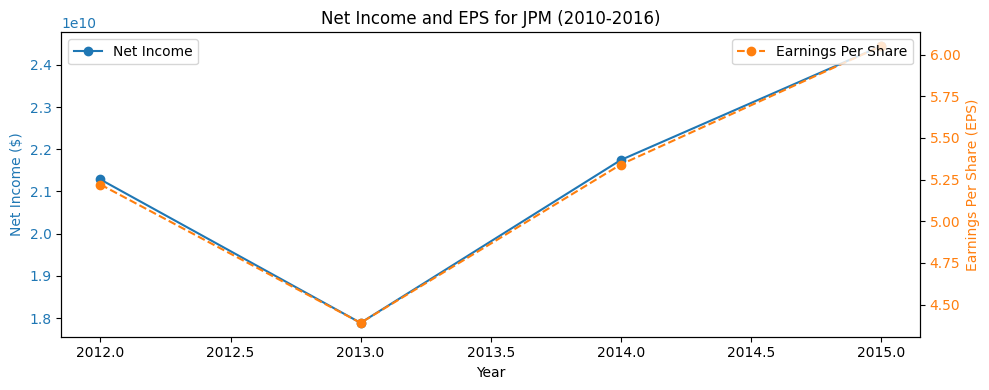

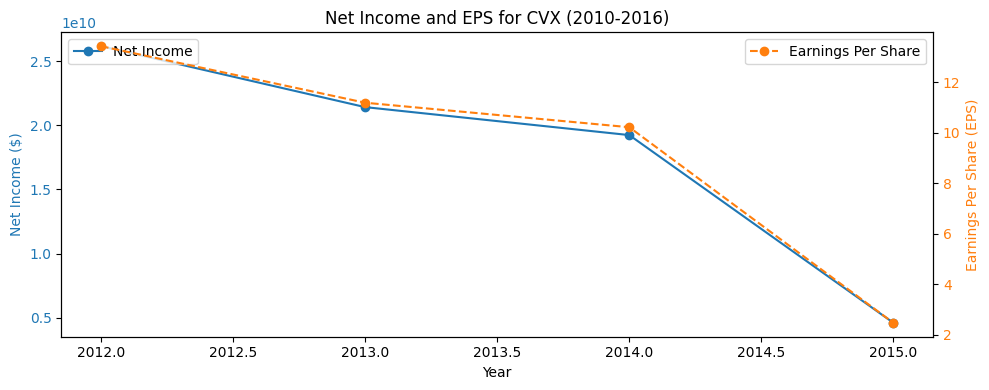

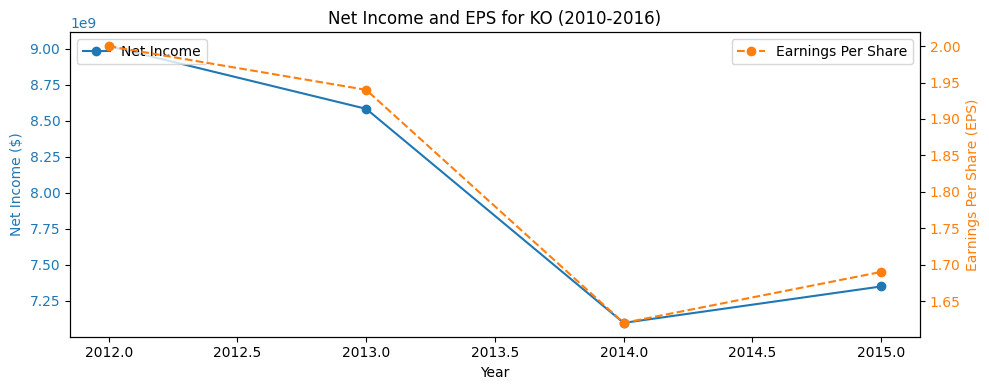

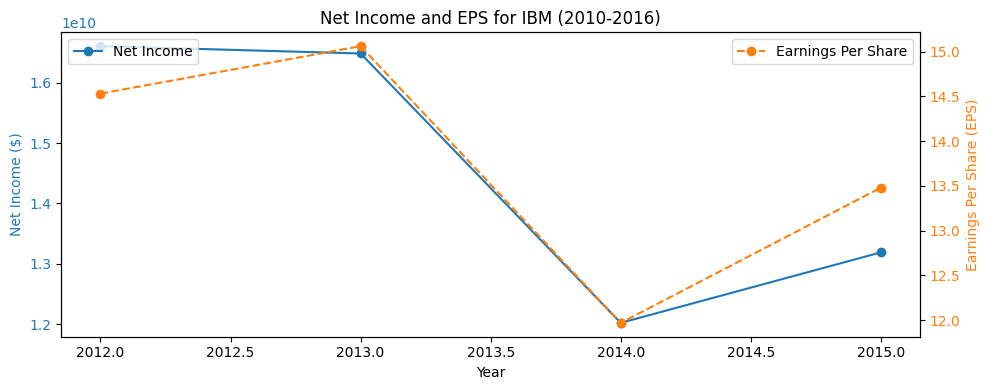

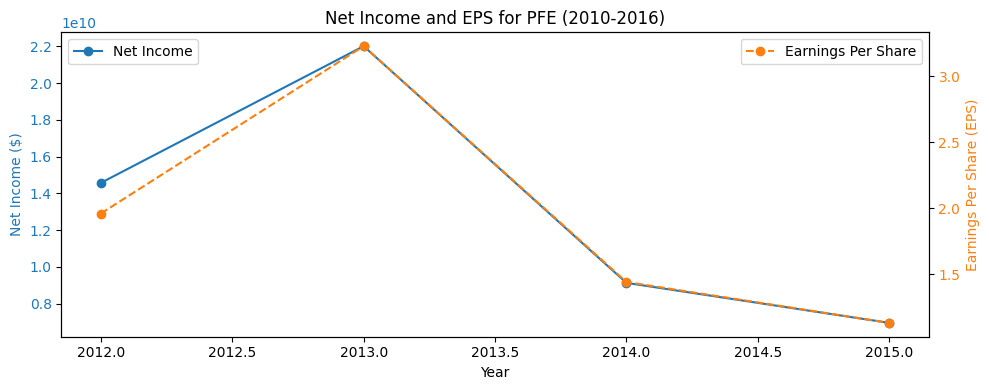

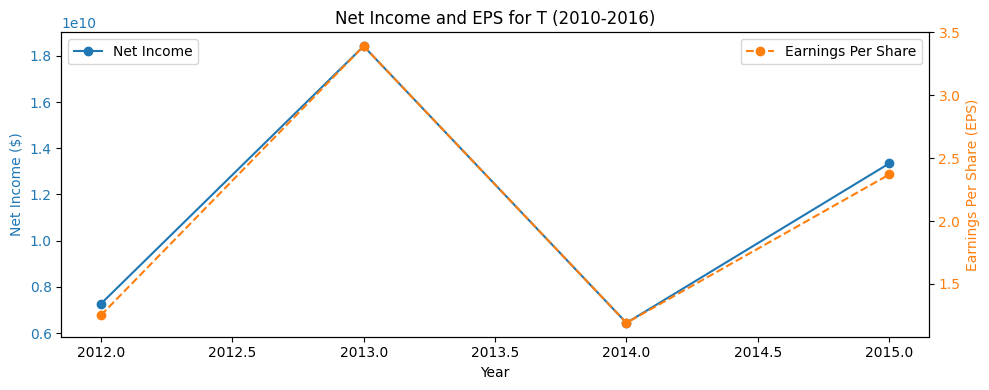

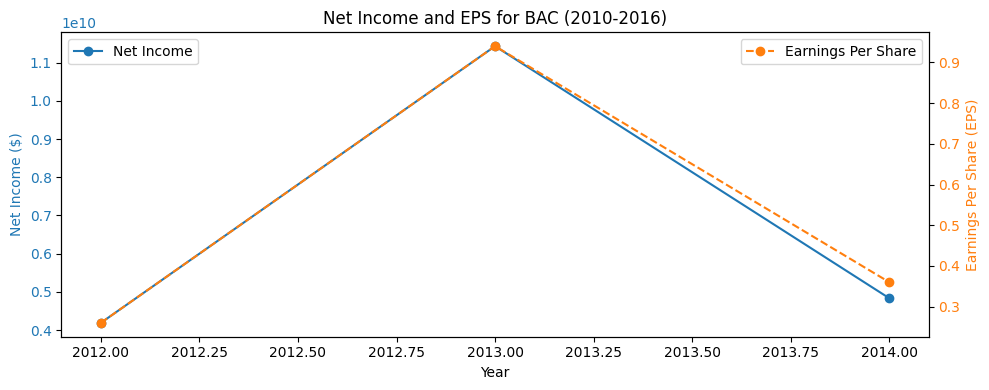

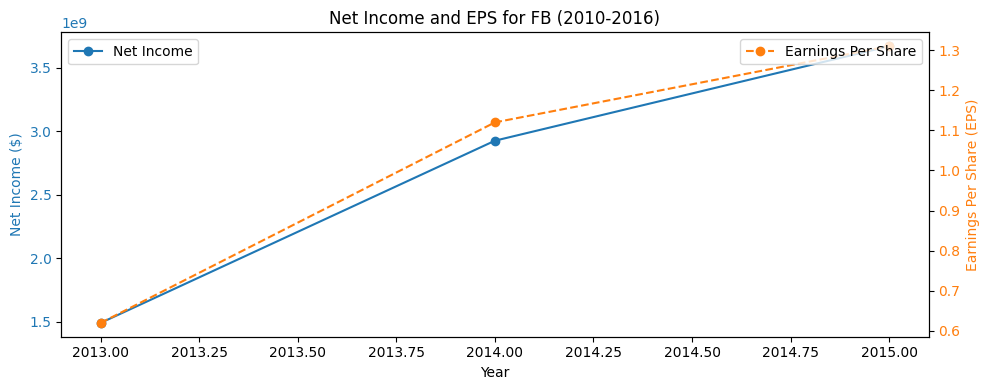

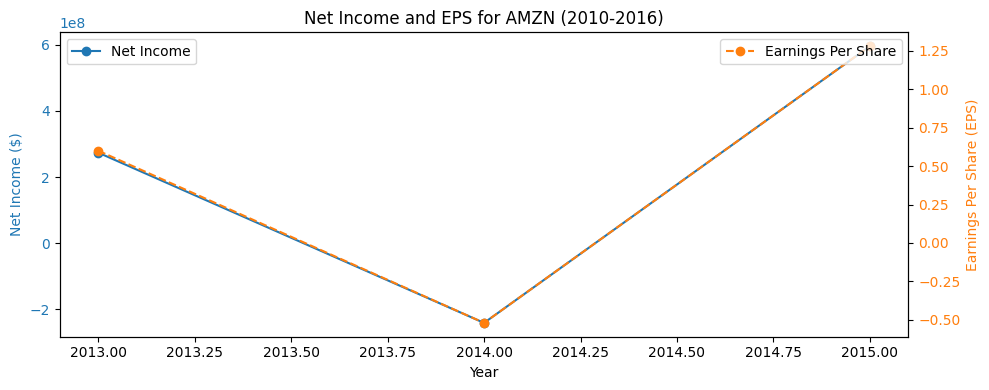

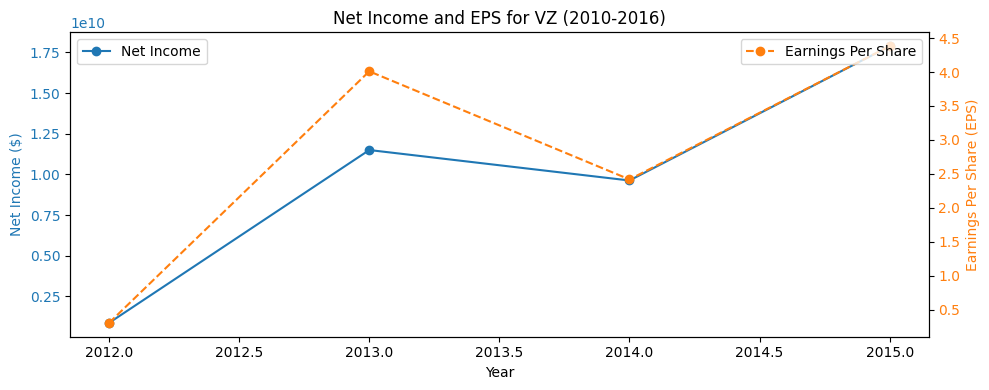

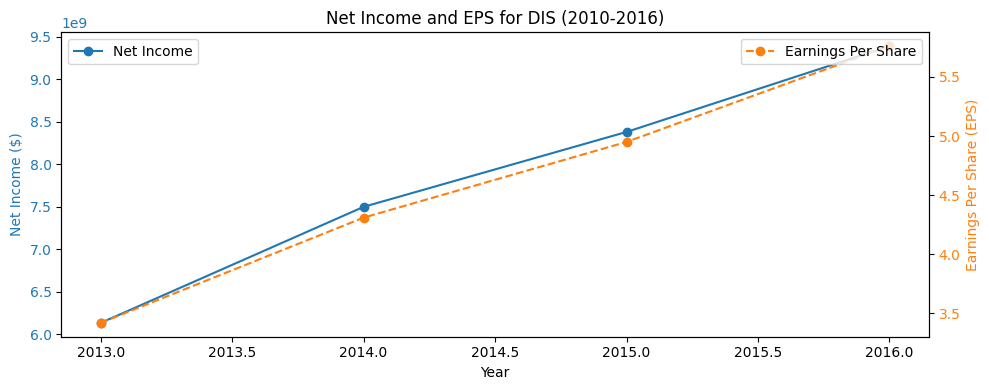

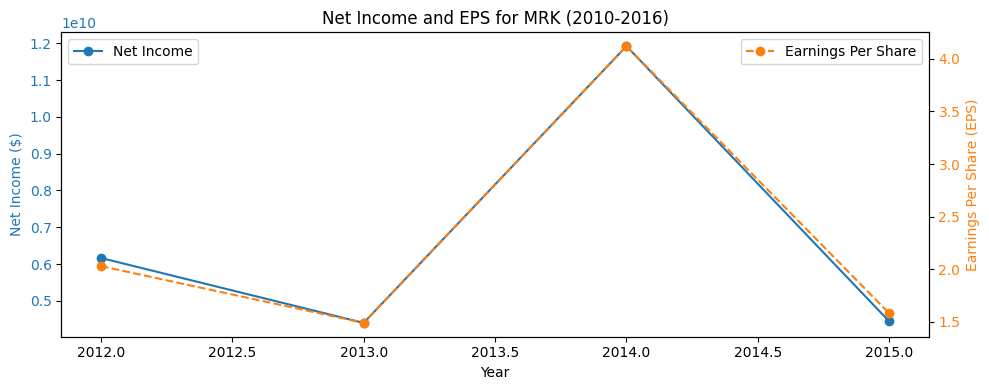

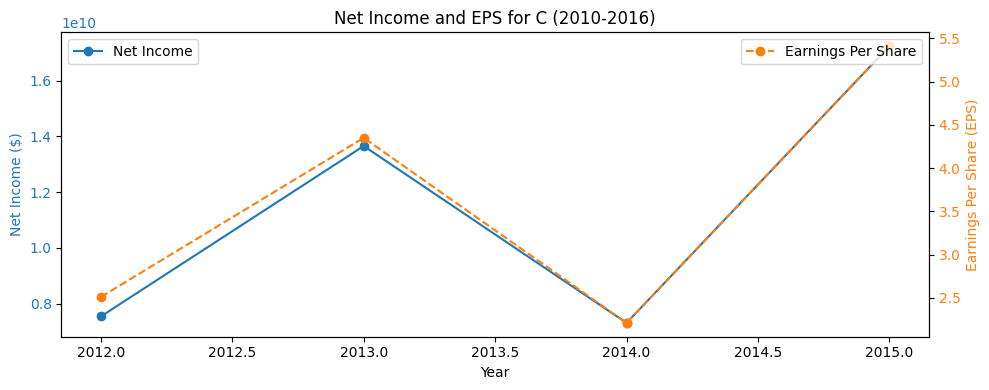

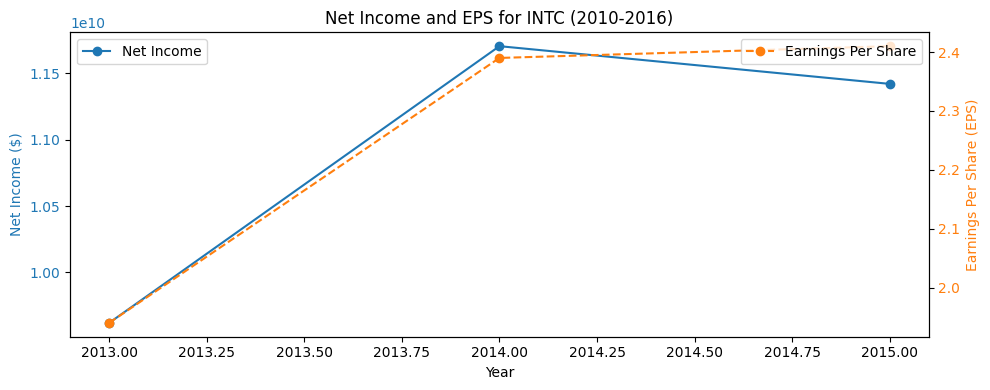

In [122]:
fundamentals = pd.read_csv('fundamentals.csv')
filtered_fundamentals = fundamentals[fundamentals['Ticker Symbol'].isin(importantCompanies)]

# Convert 'Period Ending' to datetime
filtered_fundamentals['Period Ending'] = pd.to_datetime(filtered_fundamentals['Period Ending'], errors='coerce')

# Ensure 'Net Income' and 'Earnings Per Share' are numeric
filtered_fundamentals['Net Income'] = pd.to_numeric(filtered_fundamentals['Net Income'], errors='coerce')
filtered_fundamentals['Earnings Per Share'] = pd.to_numeric(filtered_fundamentals['Earnings Per Share'], errors='coerce')

# Plot Net Income and EPS for each company
plt.figure(figsize=(14, 7))

for company in importantCompanies:
    company_data = filtered_fundamentals[filtered_fundamentals['Ticker Symbol'] == company]

    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Plot Net Income
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Net Income ($)', color='tab:blue')
    ax1.plot(company_data['For Year'], company_data['Net Income'], marker='o', color='tab:blue', label='Net Income')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis to plot EPS
    ax2 = ax1.twinx()
    ax2.set_ylabel('Earnings Per Share (EPS)', color='tab:orange')
    ax2.plot(company_data['For Year'], company_data['Earnings Per Share'], marker='o', color='tab:orange', linestyle='--', label='Earnings Per Share')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Title and legend
    plt.title(f'Net Income and EPS for {company} (2010-2016)')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    fig.tight_layout()

    # Show plot
    plt.show()

From the above graphs we can say that the EPS value is propotional to the net income of the company which has to be true logically but there are even cases where the net income has dropped yet the EPS has risen. For ex : WFC in 2016 and INTC in 2015

## **Q7: Predicting Earnings Per Share - Linear Regression (10 Points)**
The fundamentals.csv file contains four years worth of profitability data on each of the companies.   Perhaps the most important number to reflect how profitable the company is the earnings per share.    There are two predictive tasks here:
<ol type="i">
<li> Use linear regression to predict the earnings per share for company X in year Y using the other variables from foundations.csv for year Y. </li>
<li> Use linear regressions to predict the earnings per share for company X in year Y using the variables from foundations.csv for year Y-1.</li>
</ol>

How good are these models and how can you tell?


### **Task i**

In [95]:
fundamentalDF = pd.read_csv('fundamentals.csv')
# Drop non-numeric columns and compute the correlation matrix
numeric_df = fundamentalDF.select_dtypes(include=[float, int])  # Keep only numeric columns
corr_matrix = numeric_df.corr()

# Get the top 10 features most correlated with 'Earnings Per Share'
corr_with_eps = corr_matrix['Earnings Per Share'].sort_values(ascending=False)
top_10_features = corr_with_eps.index[1:11]

# Create a new DataFrame with these top 10 features
# Drop rows where 'Earnings Per Share' is NaN
df_cleaned = numeric_df.dropna(subset=['Earnings Per Share'])

# Now reselect the features and target from the cleaned dataframe
X = df_cleaned[top_10_features]  # Features (top 10 most correlated columns)
y = df_cleaned['Earnings Per Share']  # Target (Earnings Per Share)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R-squared: 0.22056421633417111
Mean Absolute Error (MAE): 2.1124541009213114
Root Mean Squared Error (RMSE): 3.446003598163869


### **Task ii**

In [96]:

# Sort the data by 'Ticker Symbol' (company) and 'Year'
fundamentalDF = fundamentalDF.sort_values(by=['Ticker Symbol', 'For Year'])

# Group by company ('Ticker Symbol') and shift the features to match Year Y with Year Y-1 and then shift
shifted_df = fundamentalDF.groupby('Ticker Symbol').shift(1)
shifted_df.reset_index()

shifted_df = shifted_df.dropna()
# Drop columns if they exist, otherwise handle the missing columns
columns_to_drop = ['Earnings Per Share', 'Ticker Symbol', 'For Year', 'Period Ending']
available_columns_to_drop = [col for col in columns_to_drop if col in shifted_df.columns]


X = shifted_df[top_10_features]
y = shifted_df['Earnings Per Share']


#  Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

#  Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.06433941690161427
Mean Absolute Error (MAE): 1.931777737172868
Root Mean Squared Error (RMSE): 3.332997349166959


Conclusion for Q7: The above models are created using the top correlated features of the EPS value yet they perform bad. Their performance can be tested with performance metrics like R SQUARE

## **Q8: Advanced Modeling Techniques (10 Points)**
Now repeat this exercise to try to build better models for parts i and ii.    I bet that (hint) improved data preparation/normalization/feature engineering will help.  Maybe an algorithm other than linear regression (e.g. Random Forest, Nearest Neighbor, etc) will prove better training.

\[Note: [scikit-learn](https://scikit-learn.org/stable/) is a user-friendly library which is used to perform data loading, pre-processing, transformations, algorithms and metrics needed for Data Science and Machine learning\]  

Compare their performance and explain your reasoning for the differences in their performances.

In [97]:
from sklearn.ensemble import RandomForestRegressor


numeric_df = fundamentalDF.select_dtypes(include=[float, int])  # Keep only numeric columns

# Drop rows where 'Earnings Per Share' is NaN
df_cleaned = numeric_df.dropna(subset=['Earnings Per Share'])

# Now reselect the features and target from the cleaned dataframe
X = df_cleaned
y = df_cleaned['Earnings Per Share']  # Target (Earnings Per Share)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.9903565421384163
Mean Absolute Error (MAE): 0.05886178913738003
Root Mean Squared Error (RMSE): 0.38330276316072365


In [98]:
# As far as I remember Professor asked us to train a model on shifted years too

shifted_df = shifted_df.select_dtypes(include=[float, int])
X = shifted_df
y = shifted_df['Earnings Per Share']


# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest R-squared: {r2_rf}")
print(f"Random Forest Mean Absolute Error (MAE): {mae_rf}")
print(f"Random Forest Root Mean Squared Error (RMSE): {rmse_rf}")

Random Forest R-squared: 0.9810223152811982
Random Forest Mean Absolute Error (MAE): 0.058833809523809705
Random Forest Root Mean Squared Error (RMSE): 0.47467615391468476


**THANK YOU !!!**